# Содержание <a id='Content'></a>

0. [Описание задачи](#Описание_задачи)   
    0.1 [Описание данных проекта](#Data_description)     
1. [Подготовка данных](#1)    
    1.1 [Удаление дубликатов](#1.1)    
    1.2 [Работа с пропусками](#1.2)     
     1.2.1 [VehicleType - Тип кузова](#1.2.1)     
     1.2.2 [Model - модель](#1.2.2)    
     1.2.3 [NotRepaired - были ремонты](#1.2.3)    
     1.2.4 [FuelType - тип топлива](#1.2.4)     
     1.2.5 [Gearbox - коробка передач](#1.2.5)     
    1.3 [Преобразование признаков в категориальные](#1.3)    
    1.4 [Очистка данных](#1.4)    
     1.4.1 [Даты и цена](#1.4.1)     
     1.4.2 [Численные признаки и цена](#1.4.2)    
    1.5 [Приведение типов](#1.5)    
2. [Обучение моделей](#2)     
    2.1 [Подготовка признаков](#2.1)  
    2.2 [Подбор оптимальных гиперпараметров](#2.2)     
    2.2.1 [LightGMB модель](#2.2.1)    
    2.2.2 [CatBoost модель](#2.2.2)    
    2.2.3 [LinearRegressor & RandomForest модели](#2.2.3)    
3. [Анализ моделей](#3)


## 0. [Описание задачи](#Content)<a id='Описание_задачи'></a>

Данная работа посвящена предсказанию стоимости подержанных автомобилей. Сервис по продаже автомобилей разрабатывает приложение для привлечения новых клиентов. В качестве исторических данных имеется следующая информация с сервиса: технические характеристики, комплектации и цены автомобилей. 

Необходимо построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения (вероятно модель будет периодически обновляться).    
Для оценки качества моделей будет применена метрика RMSE.

## 0.1 [Описание данных](#Content)<a id='Data_description'></a>
Данные находятся в файле /datasets/autos.csv.

Признаки
- DateCrawled — дата скачивания анкеты из базы
- VehicleType — тип автомобильного кузова
- RegistrationYear — год регистрации автомобиля
- Gearbox — тип коробки передач
- Power — мощность (л. с.)
- Model — модель автомобиля
- Kilometer — пробег (км)
- RegistrationMonth — месяц регистрации автомобиля
- FuelType — тип топлива
- Brand — марка автомобиля
- NotRepaired — была машина в ремонте или нет
- DateCreated — дата создания анкеты
- NumberOfPictures — количество фотографий автомобиля
- PostalCode — почтовый индекс владельца анкеты (пользователя)
- LastSeen — дата последней активности пользователя

Целевой признак
- Price — цена (евро)

# 1. [Подготовка данных](#Content)<a id='1'></a>

In [60]:
import pandas as pd
pd.options.display.max_rows = 100

Первый этап - загрузка и изучение данных

In [61]:
path = 'https://code.s3.yandex.net/datasets/autos.csv'
data = pd.read_csv(path, parse_dates = ['DateCrawled','DateCreated','LastSeen'])
data_initial = pd.read_csv(path, parse_dates = ['DateCrawled','DateCreated','LastSeen'])

In [62]:
data.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31,0,60437,2016-04-06 10:17:21


In [63]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
DateCrawled          354369 non-null datetime64[ns]
Price                354369 non-null int64
VehicleType          316879 non-null object
RegistrationYear     354369 non-null int64
Gearbox              334536 non-null object
Power                354369 non-null int64
Model                334664 non-null object
Kilometer            354369 non-null int64
RegistrationMonth    354369 non-null int64
FuelType             321474 non-null object
Brand                354369 non-null object
NotRepaired          283215 non-null object
DateCreated          354369 non-null datetime64[ns]
NumberOfPictures     354369 non-null int64
PostalCode           354369 non-null int64
LastSeen             354369 non-null datetime64[ns]
dtypes: datetime64[ns](3), int64(7), object(6)
memory usage: 43.3+ MB


/opt/conda/lib/python3.7/site-packages/pandas/plotting/_matplotlib/misc.py:80: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
  ax.set_xlim(boundaries_list[j])
/opt/conda/lib/python3.7/site-packages/pandas/plotting/_matplotlib/misc.py:81: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.
  ax.set_ylim(boundaries_list[i])
/opt/conda/lib/python3.7/site-packages/pandas/plotting/_matplotlib/misc.py:71: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
  ax.set_xlim(boundaries_list[i])


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f3f03d5b1d0>,
      dtype=object)

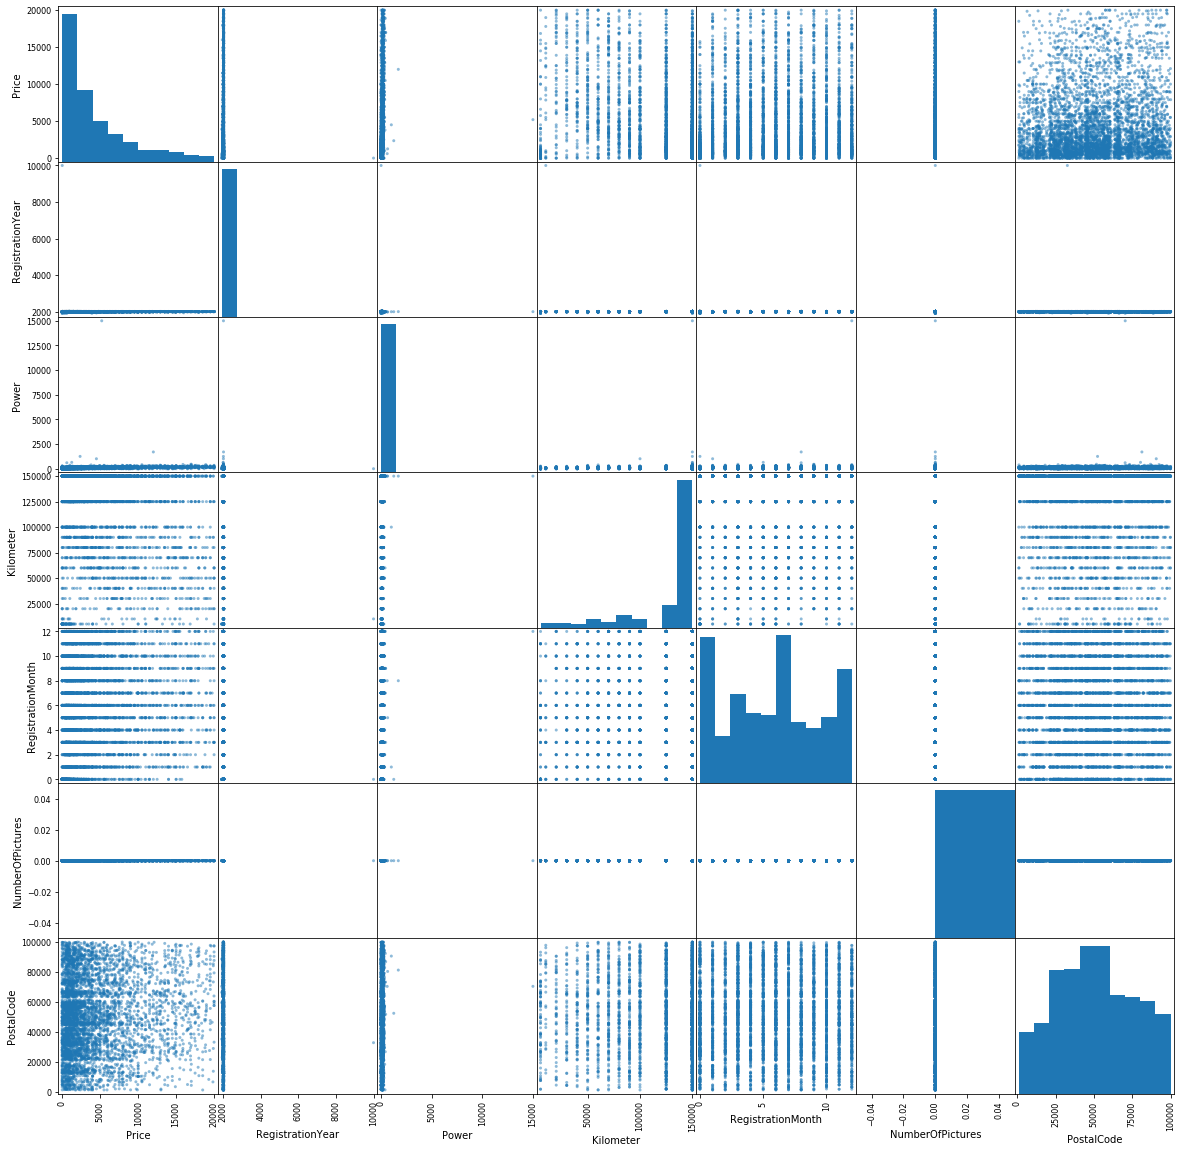

In [64]:
pd.plotting.scatter_matrix(data.sample(5000),figsize = (20,20))

Посмотрел данные и заранее преобразовал формат части данных как дата-время. 

## 1.1 [Удаление дубликатов](#Content)<a id='1.1'></a>

In [65]:
data.duplicated().sum()

4

Дубликаты имеются в наличии... Будем удалять

In [66]:
data[data.duplicated()]

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
171088,2016-03-08 18:42:48,1799,coupe,1999,auto,193,clk,20000,7,petrol,mercedes_benz,no,2016-03-08,0,89518,2016-03-09 09:46:57
231258,2016-03-28 00:56:10,1000,small,2002,manual,83,other,150000,1,petrol,suzuki,no,2016-03-28,0,66589,2016-03-28 08:46:21
258109,2016-04-03 09:01:15,4699,coupe,2003,auto,218,clk,125000,6,petrol,mercedes_benz,yes,2016-04-03,0,75196,2016-04-07 09:44:54
325651,2016-03-18 18:46:15,1999,wagon,2001,manual,131,passat,150000,7,gasoline,volkswagen,no,2016-03-18,0,36391,2016-03-18 18:46:15


In [67]:
data.drop_duplicates(inplace = True)
data.shape[0]

354365

Явные дубликаты удалены

## 1.2 [Работа с пропусками](#Content)<a id='1.2'></a>

Определим долю пропусков

In [68]:
data.isna().sum()

DateCrawled              0
Price                    0
VehicleType          37490
RegistrationYear         0
Gearbox              19833
Power                    0
Model                19705
Kilometer                0
RegistrationMonth        0
FuelType             32895
Brand                    0
NotRepaired          71154
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64

In [69]:
(data.isna().sum()/data.shape[0]*100).round(1).sort_values(ascending = False)

NotRepaired          20.1
VehicleType          10.6
FuelType              9.3
Model                 5.6
Gearbox               5.6
LastSeen              0.0
PostalCode            0.0
NumberOfPictures      0.0
DateCreated           0.0
Brand                 0.0
RegistrationMonth     0.0
Kilometer             0.0
Power                 0.0
RegistrationYear      0.0
Price                 0.0
DateCrawled           0.0
dtype: float64

видим по одним из признаков 20+ % пропущенных значений

In [70]:
def create_na_pivot(dataframe):
    columns_names_with_na = dataframe.columns[dataframe.isnull().any()].tolist()
    with_na = pd.DataFrame(columns = ['col_name_1','col_name_2','value'])
    for col_name_1 in columns_names_with_na:
        for col_name_2 in columns_names_with_na:
            counted_na = dataframe.loc[dataframe[col_name_1].isna() & dataframe[col_name_2].isna()].shape[0]
            with_na1 = pd.DataFrame([[col_name_1, col_name_2, counted_na]], columns=['col_name_1','col_name_2','value'])
            with_na = with_na.append(with_na1,ignore_index=True)
    with_na['value'] = pd.to_numeric(with_na['value'], downcast = 'integer')
    with_na = with_na.pivot_table(index = 'col_name_1', columns = 'col_name_2', values = 'value')

    return with_na

In [71]:
import seaborn as sns
import matplotlib.pyplot as plt

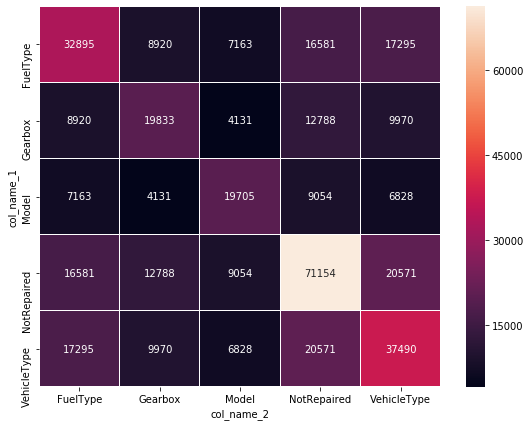

In [72]:
f, ax = plt.subplots(figsize=(9, 7))
sns.heatmap(create_na_pivot(data), annot=True, fmt=".0f", linewidths=.1)

Матрица показывает количество объектов для которых пропущенные значения по паре столбцов накладываются. 
Итак пропущены данные в: 

--------------------
- NotRepaired        |  20.1
- VehicleType     |     10.6
- FuelType         |     9.3
- Model             |    5.6
- Gearbox            |   5.6
---

Рассмотрим признаки подробнее.

### 1.2.1 [VehicleType - Тип кузова](#Content)<a id='1.2.1'></a>

In [73]:
data.columns.to_list()

['DateCrawled',
 'Price',
 'VehicleType',
 'RegistrationYear',
 'Gearbox',
 'Power',
 'Model',
 'Kilometer',
 'RegistrationMonth',
 'FuelType',
 'Brand',
 'NotRepaired',
 'DateCreated',
 'NumberOfPictures',
 'PostalCode',
 'LastSeen']

In [74]:
temp = data[['Brand','Model','VehicleType','Price']]

In [75]:
pd.set_option("display.max_rows", 101)

In [76]:
groupedVhcl = temp.groupby(['Brand','Model'])['VehicleType'].agg(lambda x:x.value_counts().index[0])
groupedVhcl

Brand       Model   
alfa_romeo  145         small
            147         sedan
            156         wagon
            159         wagon
            other       sedan
                        ...  
volvo       v40         wagon
            v50         wagon
            v60         wagon
            v70         wagon
            xc_reihe      suv
Name: VehicleType, Length: 297, dtype: object

Заполнять пропуски в типе кузова будем по наиболее часто встречающемуся значению в рамках данной модели.

In [77]:
Model_VhclType = data.groupby(['Brand','Model']).VehicleType.apply(lambda x: x.mode()[0])

In [78]:
Model_VhclType

Brand       Model   
alfa_romeo  145         small
            147         sedan
            156         wagon
            159         wagon
            other       sedan
                        ...  
volvo       v40         wagon
            v50         wagon
            v60         wagon
            v70         wagon
            xc_reihe      suv
Name: VehicleType, Length: 297, dtype: object

In [79]:
Model_VhclType_Brand = data.groupby('Brand').VehicleType.apply(lambda x: x.mode()[0])

In [80]:
Model_VhclType_Brand

Brand
alfa_romeo              sedan
audi                    wagon
bmw                     sedan
chevrolet               small
chrysler                  bus
citroen                 small
dacia                   wagon
daewoo                  small
daihatsu                small
fiat                    small
ford                    small
honda                   sedan
hyundai                 small
jaguar                  sedan
jeep                      suv
kia                       suv
lada                      suv
lancia                  small
land_rover                suv
mazda                   sedan
mercedes_benz           sedan
mini                    small
mitsubishi              sedan
nissan                  small
opel                    small
peugeot                 small
porsche           convertible
renault                 small
rover                   sedan
saab                    sedan
seat                    small
skoda                   wagon
smart                   small
sons

In [81]:
Model_VhclType['volvo','v40']

'wagon'

Тип кузова наиболее вероятно зависит от марки и модели в совокупности. Думаю не будет ошибкой применить для заполнения наиболее часто встречающуюся комбинацию для модель/марка/кузов

In [82]:
def fill_vhcl_type(row):
    vehicle_type = Model_VhclType[row['Brand'],row['Model']]
    return vehicle_type


In [83]:
data.loc[(data['VehicleType'].isna()) & (~data['Model'].isna()),'VehicleType'] = (data
                                                                      .loc[(data['VehicleType'].isna()) & 
                                                                           (~data['Model'].isna()),:]
                                                                      .apply(fill_vhcl_type,axis=1))

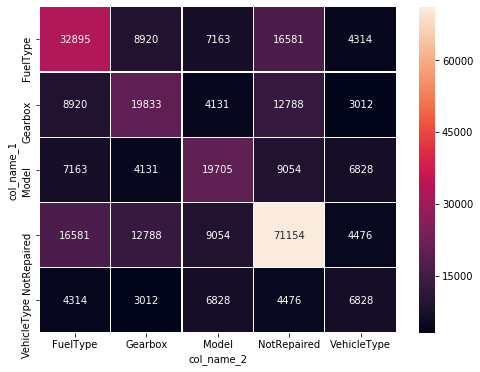

In [84]:
f, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(create_na_pivot(data), annot=True, fmt=".0f", linewidths=.1)

### 1.2.2 [Model - модель](#Content)<a id='1.2.2'></a>

Неуказанная модель автомобиля не позволяют корректно делать предсказания. Модель как правило основной параметр, влияющий на стоимость. Марка модели при этом является подкатегорией бренда и также может достаточно точно указать на кузов (например гольф => хетчбек). Но вряд ли обратный подход принесет плоды. 

In [85]:
data.groupby(by = ['Brand','Model'])['VehicleType'].value_counts().head(50)

Brand       Model   VehicleType
alfa_romeo  145     small            33
                    sedan            13
                    coupe             2
                    other             1
            147     sedan           438
                    small            97
                    coupe            27
                    other             7
                    wagon             2
                    suv               1
            156     wagon           336
                    sedan           287
                    coupe             3
                    small             2
                    other             1
            159     wagon           157
                    sedan            55
            other   sedan           215
                    coupe           180
                    small           114
                    wagon             6
                    other             5
                    convertible       1
            spider  convertible     192
        

Хорошо видно, что тип кузова не всегда четко указывает на модель. К тому же некоторые пользователи автомобилей могут вообще их путать и указать неверно. Так что пропущенные "модели" мы удалим.

In [86]:
data.shape[0] # число объектов до удаления

354365

In [87]:
data = data.dropna(subset=['Model'])

In [88]:
data.shape[0] # после удаления

334660

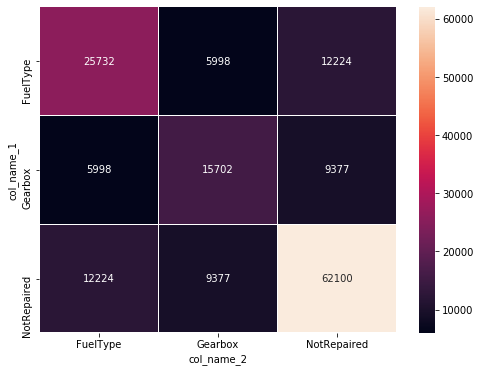

In [89]:
f, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(create_na_pivot(data), annot=True, fmt=".0f", linewidths=.1)

### 1.2.3 [NotRepaired - были ремонты](#Content)<a id='1.2.3'></a>

Рассмотрим ситуацию с ремонтами. Был - не был. 

In [90]:
data.NotRepaired.value_counts()

no     238852
yes     33708
Name: NotRepaired, dtype: int64

Как минимум можно предположить, что число ремонтов коррелирует с количеством лет, когда автомобиль был в эксплуатации. Проверим

In [91]:
data.columns

Index(['DateCrawled', 'Price', 'VehicleType', 'RegistrationYear', 'Gearbox',
       'Power', 'Model', 'Kilometer', 'RegistrationMonth', 'FuelType', 'Brand',
       'NotRepaired', 'DateCreated', 'NumberOfPictures', 'PostalCode',
       'LastSeen'],
      dtype='object')

In [92]:
data['RegistrationYear'].value_counts().head(100)

2000    22248
1999    21605
2005    21003
2006    19332
2001    19282
2003    19120
2004    19094
2002    18325
1998    16834
2007    16716
2008    15037
2009    14190
1997    13809
2010    10514
1996    10183
2011     9741
2017     9015
1995     8689
2016     8292
2012     7045
1994     4509
2013     4043
2018     3385
1993     3203
1992     2758
1991     2574
2014     2477
1990     2353
1989     1195
2015     1157
1988      871
1985      628
1987      612
1986      490
1980      440
1983      391
1984      346
1982      277
1970      242
1978      236
1979      232
1981      218
1972      179
1976      149
1977      147
1974      146
1973      145
1971      134
1975      114
1960       99
1966       88
1969       85
1967       78
1968       75
1965       62
1964       41
1963       39
1910       38
1962       33
1961       25
2019       20
1000       17
1959       17
9999       14
1950       14
1956       14
5000       14
1958       13
1955       10
1951        9
1957        9
1953  

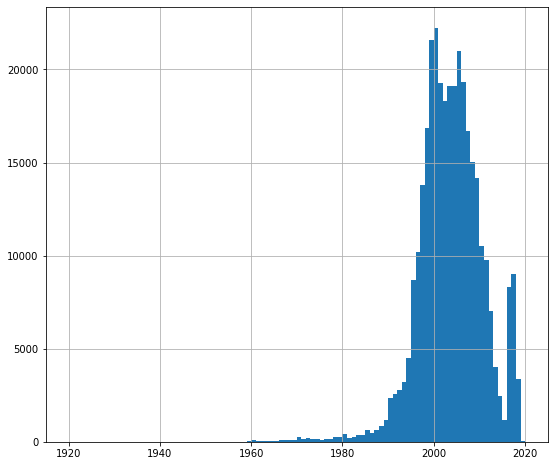

In [93]:
data['RegistrationYear'].hist(bins = 100,range=(1920, 2020),figsize = (9,8))

In [94]:
data.loc[data['RegistrationYear']<1980,:]

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
15,2016-03-11 21:39:15,450,small,1910,NaN,0,ka,5000,0,petrol,ford,NaN,2016-03-11,0,24148,2016-03-19 08:46:47
360,2016-03-17 14:52:07,10000,bus,1976,NaN,0,transporter,5000,0,petrol,volkswagen,NaN,2016-03-17,0,73479,2016-03-19 14:21:08
534,2016-03-27 10:52:55,4900,convertible,1973,manual,44,kaefer,90000,4,petrol,volkswagen,no,2016-03-27,0,16567,2016-04-07 06:44:31
630,2016-03-18 12:43:41,12000,sedan,1969,manual,140,s_klasse,80000,3,petrol,mercedes_benz,no,2016-03-18,0,46286,2016-04-05 22:16:44
981,2016-03-05 18:50:21,2900,sedan,1971,auto,90,other,90000,6,petrol,opel,no,2016-03-05,0,16356,2016-04-05 11:48:37
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
353912,2016-03-05 20:43:30,800,sedan,1970,NaN,0,other,150000,0,NaN,trabant,NaN,2016-03-05,0,1609,2016-03-12 08:17:10
354037,2016-03-23 16:57:30,10500,convertible,1968,manual,54,other,20000,4,NaN,renault,no,2016-03-23,0,63755,2016-03-25 00:47:18
354063,2016-03-08 23:37:04,0,convertible,1970,NaN,0,sl,150000,0,NaN,mercedes_benz,NaN,2016-03-08,0,34123,2016-04-07 05:15:38
354286,2016-03-21 20:44:38,16500,coupe,1973,manual,200,other,150000,6,petrol,bmw,yes,2016-03-21,0,74722,2016-04-06 19:16:32


Есть уважаемые люди, продающие авто 30х годов. И есть "футуристы-историки", которые указывают год "наобум". Как видим, никому нельзя верить... Вряд ли сервис сможет адекватно давать рекомендации по ценам для ретро автомобилей, да и по футуристам тоже. Надо ввести границы по "усам" 

In [95]:
import seaborn as sns

[(1960, 2040)]

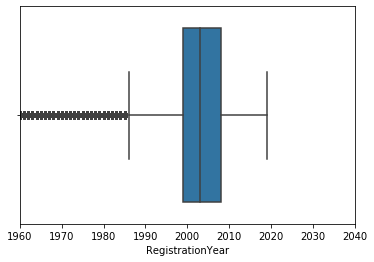

In [96]:
ax = sns.boxplot(x=data['RegistrationYear'])
ax.set(xlim=(1960, 2040))

In [97]:
data['RegistrationYear'].describe()

count    334660.000000
mean       2003.924024
std          69.377633
min        1000.000000
25%        1999.000000
50%        2003.000000
75%        2008.000000
max        9999.000000
Name: RegistrationYear, dtype: float64

Видим, что Q3-Q1 составляет всего 9 лет. Конечно мы не будем избавляться от "выбросов" самых новых объявлений. Если же взглянуть в далекое прошлое, то диапазон стоит взять $9*1.5 = 27$. $1999 - 14 = 1985$. 

In [98]:
data.loc[(data['RegistrationYear']>1984) & (data['RegistrationYear']<2020),:].shape[0]/data.shape[0] 
# вычислили процент оставленных значений

0.9871182692882329

In [99]:
data = data.loc[(data['RegistrationYear']>1984) & (data['RegistrationYear']<2020),:] # Почистили датасет

Проверим время эксплуатации в годах на момент подачи объявления. Условно говоря - возраст авто. 

In [100]:
data['Expluatation'] = data['DateCreated'].dt.year - data['RegistrationYear']

In [101]:
data.loc[data['Expluatation']<0,:].head(5)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen,Expluatation
22,2016-03-23 14:52:51,2900,bus,2018,manual,90,meriva,150000,5,petrol,opel,no,2016-03-23,0,49716,2016-03-31 01:16:33,-2
26,2016-03-10 19:38:18,5555,sedan,2017,manual,125,c4,125000,4,NaN,citroen,no,2016-03-10,0,31139,2016-03-16 09:16:46,-1
48,2016-03-25 14:40:12,7750,sedan,2017,manual,80,golf,100000,1,petrol,volkswagen,NaN,2016-03-25,0,48499,2016-03-31 21:47:44,-1
51,2016-03-07 18:57:08,2000,small,2017,manual,90,punto,150000,11,gasoline,fiat,yes,2016-03-07,0,66115,2016-03-07 18:57:08,-1
57,2016-03-10 20:53:19,2399,other,2018,manual,64,other,125000,3,NaN,seat,no,2016-03-10,0,33397,2016-03-25 10:17:37,-2


Удивительное рядом: пытаясь выяснить время эксплуатации в годах на момент подачи объявления я получил по части позиций отрицательные значения: Объявление подано раньше регстрации автомобиля. Проверим даты создания и скачивания анкеты

In [102]:
data.query('DateCrawled < DateCreated')

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen,Expluatation


Похоже регистрация событий в системе все же происходит автоматизированным образом. Так что вероятнее всего неверный год регистрации - ошибка заполнения анкеты пользователем. Для таких значений я приму предположение, что пользователь ошибся и нажал вместо нуля единицу при заполнении года. Но вообще процент ошибок меня смущает. 

Просьба поправить, если не прав.

In [103]:
data.loc[data['Expluatation']<0,'RegistrationYear'] = data.loc[data['Expluatation']<0,'RegistrationYear'] - 10
data['Expluatation'] = data['DateCreated'].dt.year - data['RegistrationYear']
data.loc[data['Expluatation']<0,:]

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen,Expluatation


In [104]:
check_repair = data.pivot_table(columns = 'NotRepaired',index = 'Expluatation',values = 'Brand', aggfunc = 'count')
check_repair

NotRepaired,no,yes
Expluatation,,
0,3413,1143
1,961,56
2,2239,96
3,3663,129
4,6373,240
5,8731,373
6,9285,441
7,12350,721
8,14857,911


In [105]:
repair = check_repair['yes']/(check_repair['no']+check_repair['yes'])
repair

Expluatation
0     0.250878
1     0.055064
2     0.041113
3     0.034019
4     0.036292
5     0.040971
6     0.045342
7     0.055160
8     0.057775
9     0.097438
10    0.080774
11    0.104102
12    0.099982
13    0.116007
14    0.126061
15    0.147796
16    0.181718
17    0.178093
18    0.194592
19    0.207998
20    0.197139
21    0.219814
22    0.199185
23    0.198929
24    0.179380
25    0.167084
26    0.188219
27    0.172678
28    0.120795
29    0.191630
30    0.187668
31    0.169444
dtype: float64

"Процент ремонта" посчитанный выше может трактоваться очень по-разному. Вероятнее всего это просто обращения в сервис, а не ремонты после серьезных ДТП. И это как правило "накопленная" история авто. Боюсь она также может быть утеряна в ходе перепродажи. Так что она вряд ли является показательной характеристикой авто при вычислении цены. Тем не менее мы ее восстановим по принципу случайного распределения.

In [106]:
import random

In [107]:
def fill_repair(years):
    return random.choices(['yes', 'no'], [repair[years],1-repair[years]])[0]

In [108]:
fill_repair(5)

'no'

In [109]:
data.loc[(data['NotRepaired'].isna()),'NotRepaired'] = (data
                                                        .loc[(data['NotRepaired'].isna()),'Expluatation']
                                                        .apply(fill_repair))

In [110]:
data.loc[(data['NotRepaired'].isna()),:]

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen,Expluatation


In [111]:
data.NotRepaired.value_counts()

no     287978
yes     42371
Name: NotRepaired, dtype: int64

### 1.2.4 [FuelType - тип топлива](#Content)<a id='1.2.4'></a>

Рассмотрим ситуацию с типом топлива

In [112]:
data.FuelType.value_counts(dropna = False)

petrol      204004
gasoline     95532
NaN          24963
lpg           4929
cng            541
hybrid         207
other          108
electric        65
Name: FuelType, dtype: int64

In [113]:
data.query('Model =="golf" & FuelType == ["petrol", "gasoline"] & Power==105 & RegistrationYear ==2016').iloc[20:40]

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen,Expluatation
251465,2016-03-14 08:51:57,11400,sedan,2016,auto,105,golf,40000,3,gasoline,volkswagen,no,2016-03-14,0,30457,2016-03-24 16:17:58,0
259919,2016-03-21 07:36:25,800,sedan,2016,manual,105,golf,150000,7,petrol,volkswagen,no,2016-03-21,0,1900,2016-03-29 16:47:18,0
309453,2016-04-02 10:49:22,8500,sedan,2016,manual,105,golf,150000,6,gasoline,volkswagen,no,2016-04-02,0,26529,2016-04-06 08:45:04,0
321313,2016-04-04 15:44:27,6000,sedan,2016,manual,105,golf,150000,10,gasoline,volkswagen,no,2016-04-04,0,53489,2016-04-06 17:15:31,0
329856,2016-03-10 15:47:15,2900,sedan,2016,manual,105,golf,125000,10,petrol,volkswagen,no,2016-03-10,0,36137,2016-03-16 02:16:57,0
332630,2016-04-02 11:51:53,4500,sedan,2016,manual,105,golf,150000,0,gasoline,volkswagen,no,2016-04-02,0,47809,2016-04-06 09:46:07,0
332728,2016-03-28 22:55:08,5600,sedan,2016,manual,105,golf,150000,11,gasoline,volkswagen,no,2016-03-28,0,14050,2016-04-05 12:45:48,0
335171,2016-03-27 14:47:48,4490,sedan,2016,manual,105,golf,150000,1,gasoline,volkswagen,no,2016-03-27,0,37520,2016-03-27 14:47:48,0


Думаю petrol и gasoline - одно и то же. https://en.wikipedia.org/wiki/Gasoline
Признак можно унифицировать.
Из моего опыта - gasoline называют бензин в Германии. Похоже регион у нас - Евросоюз.

In [114]:
data['FuelType'] = data.FuelType.apply(lambda x: 'petrol' if x=='gasoline' else x)

Почти гарантированно зная марку и модель автомобиля + его мощность можно достоверно установить тип топлива, которое он потребляет. Проверим догадку.

In [115]:
new_table = data[['Model','Power','FuelType','Brand']]
new_table = new_table.loc[new_table['FuelType'].notna(),:]
new_table

,Model,Power,FuelType,Brand
0,golf,0,petrol,volkswagen
2,grand,163,petrol,jeep
3,golf,75,petrol,volkswagen
4,fabia,69,petrol,skoda
5,3er,102,petrol,bmw
...,...,...,...,...
354363,zafira,0,petrol,opel
354364,colt,0,petrol,mitsubishi
354366,fortwo,101,petrol,smart
354367,transporter,102,petrol,volkswagen


In [116]:
groupedVhcl = (new_table
               .groupby(['Model','Power'])['FuelType']
               .agg(lambda x:x.value_counts().index[0]))

In [117]:
groupedVhcl

Model   Power
100     0        petrol
        75       petrol
        82       petrol
        85       petrol
        90       petrol
                  ...  
zafira  300      petrol
        1001     petrol
        1100     petrol
        1779     petrol
        12512    petrol
Name: FuelType, Length: 8865, dtype: object

groupedVhcl - таблица, в которой представлены наиболее популярные виды топлива в зависимости от марки и мощности автомобиля. Вроде как получается разговор у гаража: 
 - У тебя что за модель?
 - Forester
 - А сколько лошадей?
 - 230
 - Бензиновый наверное?
 - Ага. Как догадался?
 - У друга такой же.

Реализуем заполнение пропусков.

In [118]:
def fill_FuelType(row):
    ft = 'petrol'
    model_gr = groupedVhcl[row['Model']]    
    if row['Power'] in list(model_gr.index):
        ft = model_gr[row['Power']]
    else:
        ft = groupedVhcl[row['Model']].mode()[0]
    return ft

In [119]:
data.loc[data['FuelType'].isna(),'FuelType'] = (data.loc[data['FuelType'].isna(),:].apply(fill_FuelType,axis=1))

In [120]:
data.loc[data['FuelType'].isna(),:] 

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen,Expluatation


Думаю вообще с такой задачей отлично и деревья справятся. А лес тем более... Но у меня все логичнее

### 1.2.5 [Gearbox - коробка передач](#Content)<a id='1.2.5'></a>

Разберемся с коробками передач. Сначала просто проверим значения, введенные в базу автомобилей:

In [121]:
data.Gearbox.value_counts(dropna = False)

manual    253218
auto       62185
NaN        14946
Name: Gearbox, dtype: int64

Всего два варианта - уже радует)

Проблема в другом: мы не можем на основе данных заполнить пропуски. Любой автомобиль как правило продается с обеими типами коробки передач. Пользователь выбирает модификацию сам. можно попробовать посмотреть соотношения по возрастам. Конечно коробка влияет на цену автомобиля. Но заполнять пропуск по цене означает утечку целевого признака - недопустимо. 

Проверим корреляцию коробка-цена. Будет "пятно" - смысла брать признак в рассмотрение нет. 

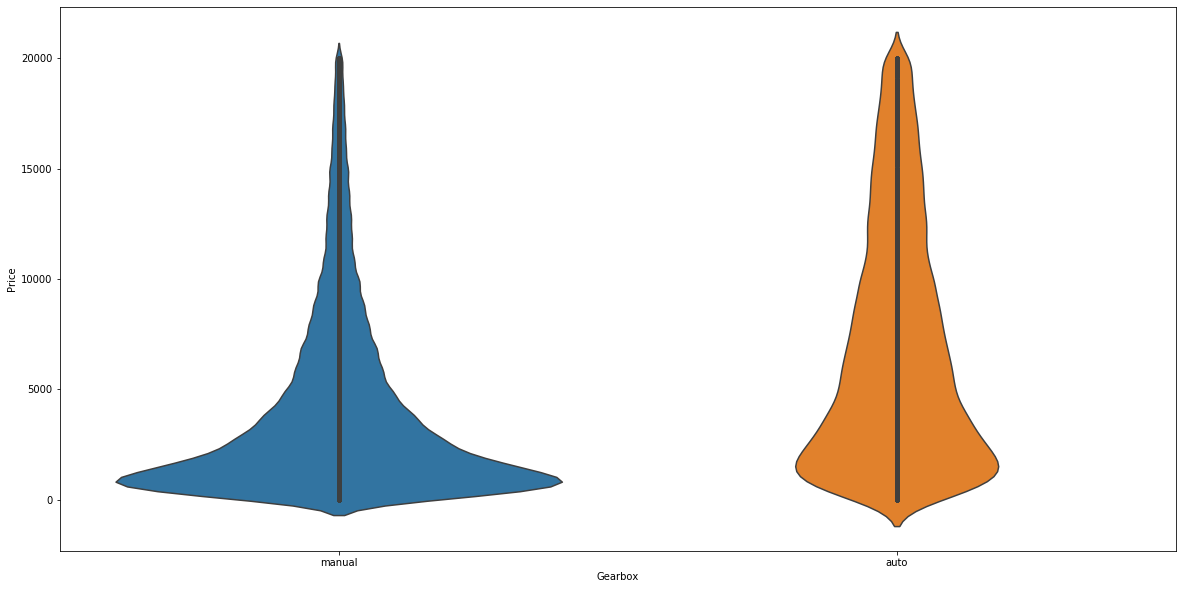

In [122]:
# Show each distribution with both violins and points
plt.figure(figsize=(20,10))
ax = sns.violinplot(data=data[['Gearbox','Price']],x='Gearbox',y='Price', inner="points")

In [123]:
info = data[['Price','Gearbox']]
info.query('Gearbox == "auto"').describe()

,Price
count,62185.000000
mean,6889.092370
std,5390.556307
min,0.000000
25%,2300.000000
50%,5500.000000
75%,10500.000000
max,20000.000000


In [124]:
info.query('Gearbox == "manual"').describe()

,Price
count,253218.000000
mean,4022.305756
std,4131.162864
min,0.000000
25%,1000.000000
50%,2500.000000
75%,5650.000000
max,20000.000000


Цена определенно зависит от коробки переключения передач. И явных корреляций нет между коробкой и другими признаками. 
Потому будем производить удаление позиций с пропущенными значениями


In [125]:
data.dropna(how = 'any', inplace = True)
data.query('Gearbox.isna()')

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen,Expluatation


## 1.3 [Преобразование признаков в категориальные](#Content)<a id='1.3'></a>

Рассмотрим почтовые индексы.

In [126]:
data.PostalCode.value_counts().tail(20)

36169    1
95356    1
82445    1
91289    1
82493    1
12625    1
55499    1
79595    1
8648     1
97528    1
25599    1
67311    1
83546    1
82447    1
82404    1
86502    1
24814    1
86684    1
93189    1
67587    1
Name: PostalCode, dtype: int64

In [127]:
data.PostalCode.sort_values()

56057      1067
257910     1067
73137      1067
282753     1067
327001     1067
          ...  
255284    99998
162735    99998
279174    99998
267251    99998
117149    99998
Name: PostalCode, Length: 315403, dtype: int64

In [128]:
data.PostalCode.value_counts().head(20)

10115    806
65428    559
66333    300
44145    287
32257    279
52525    278
60311    265
38518    258
61169    252
78224    252
13357    252
48249    251
50354    246
26789    245
53757    245
40764    243
60386    242
52249    235
48599    234
92637    230
Name: PostalCode, dtype: int64

Речь идет об индексах. В конце концов индекс указывает на место. Наша задача превратить их огромное количество в ограниченный набоh категорий. Индекс указывает на конкретное почтовое отделение. Этот номер мы укрупним до города

http://download.geonames.org/export/zip/

In [129]:
postals = pd.read_csv('allCountries.csv', sep = '\t',names = ['Country','PostalCode'],usecols = [0,1])

/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3051: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [130]:
data.dtypes

DateCrawled          datetime64[ns]
Price                         int64
VehicleType                  object
RegistrationYear              int64
Gearbox                      object
Power                         int64
Model                        object
Kilometer                     int64
RegistrationMonth             int64
FuelType                     object
Brand                        object
NotRepaired                  object
DateCreated          datetime64[ns]
NumberOfPictures              int64
PostalCode                    int64
LastSeen             datetime64[ns]
Expluatation                  int64
dtype: object

In [131]:
postals['PostalCode'] = postals['PostalCode'].astype(str)
postals

,Country,PostalCode
0,AD,AD100
1,AD,AD200
2,AD,AD400
3,AD,AD300
4,AD,AD600
...,...,...
1530479,ZA,9982
1530480,ZA,9986
1530481,ZA,9986
1530482,ZA,9987


Как видим - коды могут быть буквенно-численными, а в базе автомобилей они только численные. 
Стоит попробовать упростить базу почтовых кодов. 

In [132]:
import re

In [133]:
postals['PostalCode'] = postals['PostalCode'].str.extract(r'(\d+)', expand=False)

In [134]:
postals.loc[postals['PostalCode']=='194021',:]

,Country,PostalCode
1259208,RU,194021


In [135]:
postals = postals.dropna()
postals['PostalCode_int'] = postals['PostalCode'].astype(int)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [136]:
postals = postals.query('PostalCode_int>1000 & PostalCode_int<100000')
postals

,Country,PostalCode,PostalCode_int
7,AR,3636,3636
8,AR,4123,4123
9,AR,4126,4126
10,AR,4126,4126
11,AR,4126,4126
...,...,...,...
1530479,ZA,9982,9982
1530480,ZA,9986,9986
1530481,ZA,9986,9986
1530482,ZA,9987,9987


In [137]:
needed_codes = data.PostalCode.unique()

In [138]:
postals = postals.loc[postals.PostalCode_int.isin(needed_codes),:]

In [139]:
postals.loc[postals['PostalCode']=='46145',:]

,Country,PostalCode,PostalCode_int
110627,DE,46145,46145
178854,ES,46145,46145
178855,ES,46145,46145
701081,MX,46145,46145
1435980,TR,46145,46145


Конечно мы видим, что часть кодов повторяется. Но будем считать, что в целом мы попадаем в один регион мира

In [140]:
def fill_region(postal_code):   
    postal_code = str(postal_code)
    result = postals.query('PostalCode == @postal_code').iloc[0]
    return result.Country

In [141]:
%%time
data.iloc[1000:2000].PostalCode.apply(fill_region)

CPU times: user 4.46 s, sys: 2.52 ms, total: 4.46 s
Wall time: 4.47 s


1133    DE
1134    DE
1135    DE
1136    DE
1137    DE
        ..
2247    DE
2248    DE
2249    DE
2250    DE
2251    DE
Name: PostalCode, Length: 1000, dtype: object

Работает долго. Переведем в словарь postals:

In [142]:
%%time
# postals_dict  = postals.groupby('PostalCode').first().Country.to_dict()

postals_dict = (postals
                .groupby(['PostalCode', 'Country'])
                .apply(pd.DataFrame.mode)
                .set_index('PostalCode')
                .Country
                .to_dict())

CPU times: user 1min 33s, sys: 379 ms, total: 1min 34s
Wall time: 1min 34s


In [143]:
#postals['PostalCode'] = postals['PostalCode'].astype(int)

In [144]:
def fill_region_simple(postal_code):   
    postal_code = str(postal_code)
    if postal_code in postals_dict:
        result = postals_dict[postal_code]
    elif '0'+postal_code in postals_dict:
        result = postals_dict['0'+postal_code]
    else:
        result = 'unknown'
    return result

In [145]:
postals_dict

{'010115': 'RO',
 '010117': 'RO',
 '010119': 'RO',
 '010178': 'RO',
 '010179': 'RO',
 '010243': 'RO',
 '010365': 'RO',
 '010367': 'RO',
 '010405': 'RO',
 '010407': 'RO',
 '010435': 'RO',
 '010437': 'RO',
 '010551': 'RO',
 '010553': 'RO',
 '010555': 'RO',
 '010557': 'RO',
 '010559': 'RO',
 '010585': 'RO',
 '010587': 'RO',
 '010623': 'RO',
 '010625': 'RO',
 '010627': 'RO',
 '010629': 'RO',
 '01067': 'KR',
 '01068': 'KR',
 '01069': 'KR',
 '010707': 'RO',
 '010709': 'RO',
 '010711': 'RO',
 '010713': 'RO',
 '010715': 'RO',
 '010717': 'RO',
 '010719': 'RO',
 '010777': 'RO',
 '010779': 'RO',
 '010781': 'RO',
 '010783': 'RO',
 '010785': 'RO',
 '010787': 'RO',
 '010823': 'RO',
 '010825': 'RO',
 '010827': 'RO',
 '010961': 'RO',
 '010963': 'RO',
 '010965': 'RO',
 '010967': 'RO',
 '01097': 'KR',
 '01099': 'KR',
 '01108': 'LT',
 '01109': 'LT',
 '01127': 'LT',
 '01129': 'LT',
 '01139': 'LT',
 '01156': 'KR',
 '01157': 'KR',
 '01159': 'KR',
 '01169': 'KR',
 '01187': 'KR',
 '01189': 'KR',
 '012051': 'R

In [146]:
fill_region_simple(1067)

'PT'

In [147]:
fill_region_simple(4668)

'US'

In [148]:
fill_region_simple(9599)

'DE'

In [149]:
%%time
data.iloc[1000:2000].PostalCode.apply(fill_region_simple)

CPU times: user 2.52 ms, sys: 67 µs, total: 2.59 ms
Wall time: 2.45 ms


1133    DE
1134    DE
1135    US
1136    DE
1137    US
        ..
2247    UA
2248    US
2249    UA
2250    US
2251    MX
Name: PostalCode, Length: 1000, dtype: object

Чудеса! быстро и точно!

In [150]:
data['Country'] =  data.PostalCode.apply(fill_region_simple)

In [151]:
data.Country.value_counts()

US         135813
UA          50485
DE          41017
MX          34373
KR          19568
FR           6517
ZA           3882
ES           3180
EE           2941
TR           2731
PK           2536
NO           1491
IT           1262
PH           1254
MY           1095
RS           1030
PE            855
LT            841
PT            575
LK            544
NZ            495
NL            488
LU            406
TH            335
SI            315
RE            222
BG            156
FI            134
CH            133
UY            123
GP            122
MD            106
MQ            103
GF             94
DK             63
HU             35
BE             34
PM             15
DZ             15
YT              9
AU              9
unknown         1
Name: Country, dtype: int64

In [152]:
postals_dict2  = postals.groupby('PostalCode').first().Country.to_dict() #пробуем восстановить по-другому(первая позиция кода)

In [153]:
def fill_region_simple2(postal_code):   
    postal_code = str(postal_code)
    if postal_code in postals_dict:
        result = postals_dict2[postal_code]
    elif '0'+postal_code in postals_dict:
        result = postals_dict2['0'+postal_code]
    else:
        result = 'unknown'
    return result

In [154]:
data['Country2'] = data.PostalCode.apply(fill_region_simple2)

In [155]:
data.Country2.value_counts()

DE         284302
BR          15023
AR           4258
AU           2566
AT           2416
BG           2343
CH           1331
CR            512
AZ            469
DK            424
HU            393
LU            333
BE            291
BD            257
NL            143
NO            115
NZ             58
PH             53
MX             35
ES             33
ZA             12
MY             10
KR             10
DZ              5
US              3
PT              2
IT              2
unknown         1
PK              1
UA              1
FR              1
Name: Country2, dtype: int64

В этот момент я понял, что нет смысла заниматься восстановлением по георафии: первые позиции меняются в зависимости от выбора способа восстановления по индексам. В одном случае - лидер США, в другом - Германия. Потому занятие это просто бесполезное. 
Тут надо уточнять, где находятся географически пользователи сервиса. 

Информацию о кодах удаляем как и ее производные

In [156]:
data.drop(columns = ['Country','Country2','PostalCode'],inplace = True)

In [157]:
data.dtypes

DateCrawled          datetime64[ns]
Price                         int64
VehicleType                  object
RegistrationYear              int64
Gearbox                      object
Power                         int64
Model                        object
Kilometer                     int64
RegistrationMonth             int64
FuelType                     object
Brand                        object
NotRepaired                  object
DateCreated          datetime64[ns]
NumberOfPictures              int64
LastSeen             datetime64[ns]
Expluatation                  int64
dtype: object

## 1.4 [EDA и Очистка данных](#Content)<a id='1.4'></a>

Под данным заголовком я подразумеваю обработку аномальных численных значений и выбросов. Другой немаловажный аспект - какие данные стоит убрать из рассмотрения?

Особенно это касается стоимостей автомобилей - целевого признака. 

In [158]:
data.dtypes

DateCrawled          datetime64[ns]
Price                         int64
VehicleType                  object
RegistrationYear              int64
Gearbox                      object
Power                         int64
Model                        object
Kilometer                     int64
RegistrationMonth             int64
FuelType                     object
Brand                        object
NotRepaired                  object
DateCreated          datetime64[ns]
NumberOfPictures              int64
LastSeen             datetime64[ns]
Expluatation                  int64
dtype: object

**Описание данных**

Признаки
- DateCrawled — дата скачивания анкеты из базы
- DateCreated — дата создания анкеты
- LastSeen — дата последней активности пользователя
- VehicleType — тип автомобильного кузова
- RegistrationYear — год регистрации автомобиля
- Gearbox — тип коробки передач
- Power — мощность (л. с.)
- Model — модель автомобиля
- Kilometer — пробег (км)
- RegistrationMonth — месяц регистрации автомобиля
- FuelType — тип топлива
- Brand — марка автомобиля
- NotRepaired — была машина в ремонте или нет
- NumberOfPictures — количество фотографий автомобиля
- PostalCode — почтовый индекс владельца анкеты (пользователя)

Целевой признак
- Price — цена (евро)

In [159]:
data.corr()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,Expluatation
Price,1.000000,0.565621,0.155159,-0.378969,0.083501,NaN,-0.565626
RegistrationYear,0.565621,1.000000,0.042194,-0.361266,0.038810,NaN,-0.999999
Power,0.155159,0.042194,1.000000,0.016221,0.025515,NaN,-0.042194
Kilometer,-0.378969,-0.361266,0.016221,1.000000,-0.018367,NaN,0.361272
RegistrationMonth,0.083501,0.038810,0.025515,-0.018367,1.000000,NaN,-0.038806
NumberOfPictures,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Expluatation,-0.565626,-0.999999,-0.042194,0.361272,-0.038806,NaN,1.000000


Что-то не так с количеством картинок

In [160]:
data.NumberOfPictures.value_counts()

0    315403
Name: NumberOfPictures, dtype: int64

Удаляем колонку

In [161]:
data.drop(columns = 'NumberOfPictures',inplace = True)

### 1.4.1 [Даты и цена](#Content)<a id='1.4.1'></a>

In [162]:
date_columns = data.select_dtypes(include='datetime64[ns]').columns
date_columns

Index(['DateCrawled', 'DateCreated', 'LastSeen'], dtype='object')

In [163]:
def print_scatter(data_EDA, columns, EDA_col_name):
    for col in columns:
        ax = sns.scatterplot(x=col, y=EDA_col_name, data=data_EDA.sample(10000))

In [164]:
data.DateCrawled.describe()

count                  315403
unique                 248816
top       2016-03-19 21:49:56
freq                        6
first     2016-03-05 14:06:22
last      2016-04-07 14:36:58
Name: DateCrawled, dtype: object

In [165]:
from matplotlib import pyplot

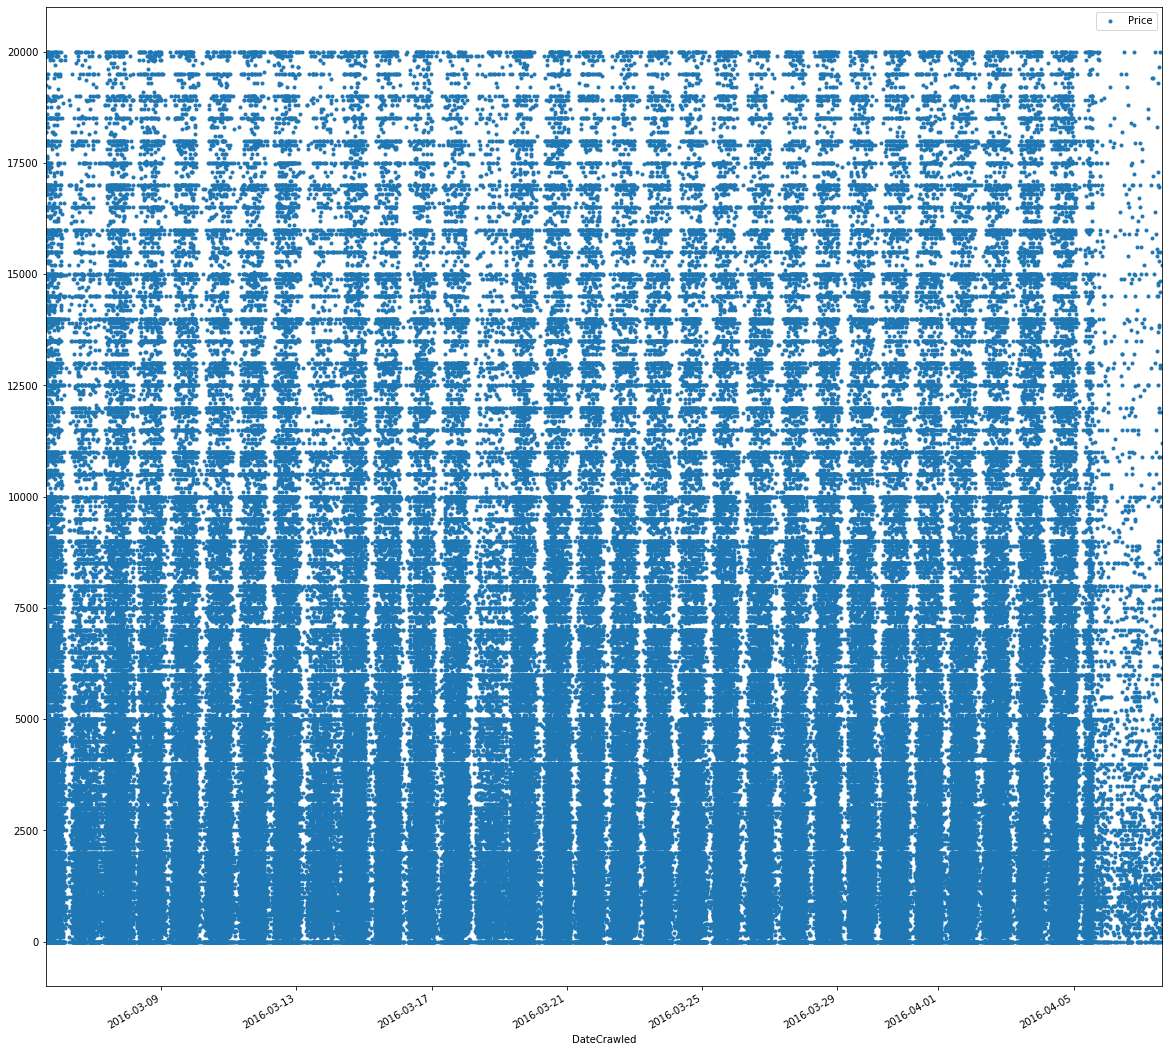

In [166]:
data.plot(x='DateCrawled', y='Price', style=".",figsize = (20,20))

Видим, что анкеты скачивали в определенные даты. По большому счету никаких зависимостей цены от этого быть не может и не должно быть. Тем более мы не можем никак подать эти данные пользователю как исходные, по которым будет работать модель. Сбор данных происходил в течение месяца. 

Единственное, эти данные можно рассматривать как оценку адекватности заполнения анкеты.

Пример: автомобиль зарегистрирован позже подачи объявления. Проверим адекватность и удалим после колонку

In [167]:
data.query('DateCrawled<DateCreated')

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,LastSeen,Expluatation


In [168]:
data.query('DateCrawled<LastSeen')

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,LastSeen,Expluatation
0,2016-03-24 11:52:17,480,sedan,1993,manual,0,golf,150000,0,petrol,volkswagen,no,2016-03-24,2016-04-07 03:16:57,23
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,petrol,jeep,no,2016-03-14,2016-04-05 12:47:46,12
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17,2016-03-17 17:40:17,15
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,petrol,skoda,no,2016-03-31,2016-04-06 10:17:21,8
5,2016-04-04 17:36:23,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes,2016-04-04,2016-04-06 19:17:07,21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354363,2016-03-27 20:36:20,1150,bus,2000,manual,0,zafira,150000,3,petrol,opel,no,2016-03-27,2016-03-29 10:17:23,16
354364,2016-03-21 09:50:58,0,sedan,2005,manual,0,colt,150000,7,petrol,mitsubishi,yes,2016-03-21,2016-03-21 10:42:49,11
354366,2016-03-05 19:56:21,1199,convertible,2000,auto,101,fortwo,125000,3,petrol,smart,no,2016-03-05,2016-03-11 18:17:12,16
354367,2016-03-19 18:57:12,9200,bus,1996,manual,102,transporter,150000,3,petrol,volkswagen,no,2016-03-19,2016-04-07 07:15:26,20


In [169]:
data.query('DateCreated>LastSeen')

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,LastSeen,Expluatation


(736028.5938425926, 736061.6242013889)

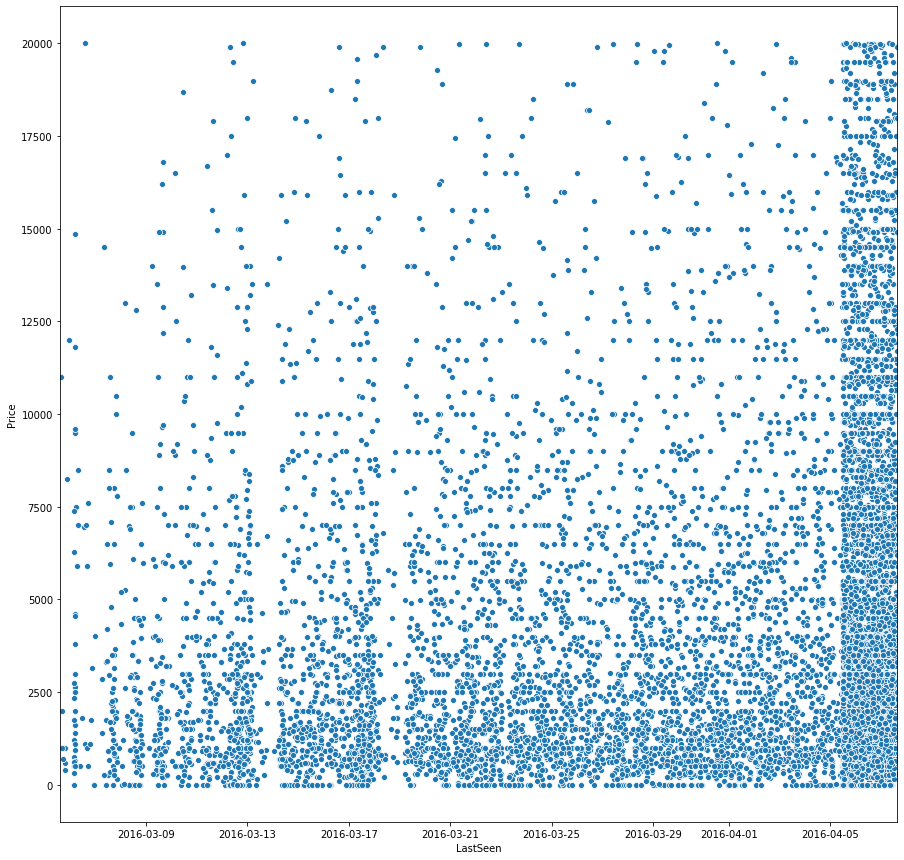

In [170]:
fig, ax = pyplot.subplots(figsize = (15,15))
# sns.jointplot(ax=ax,x='DateCrawled', y='Price', data=data.sample(10000))
sns.scatterplot(ax=ax,x='LastSeen', y='Price', data=data.sample(10000))
ax.set_xlim(data['LastSeen'].min(), data['LastSeen'].max())              

Не ясно, как в наших данных обновляются даты последнего появления пользователя. Но дата последней активности пользователя явно должна быть ранее даты скачивания анкеты. Возможно причина в обновлении даты отдельной процедурой уже внутри имеющихся скачанных анкет.
LastSeen - последняя активность пользователя также не имеет никакого отношения к цене автомобиля, по которой он выставлен. Нигде не написано, что данная активность связана с данным объявлением. Потому я удаляю эти данные

<font color='blue'><u><b>КОММЕНТАРИЙ РЕВЬЮЕРА</b></u></font><br />
<font color='green'>
и это логично)

</b></font>

In [171]:
data.drop(columns = 'DateCrawled',inplace = True)

In [172]:
data.drop(columns = 'LastSeen',inplace = True)

(735677.0, 736061.0)

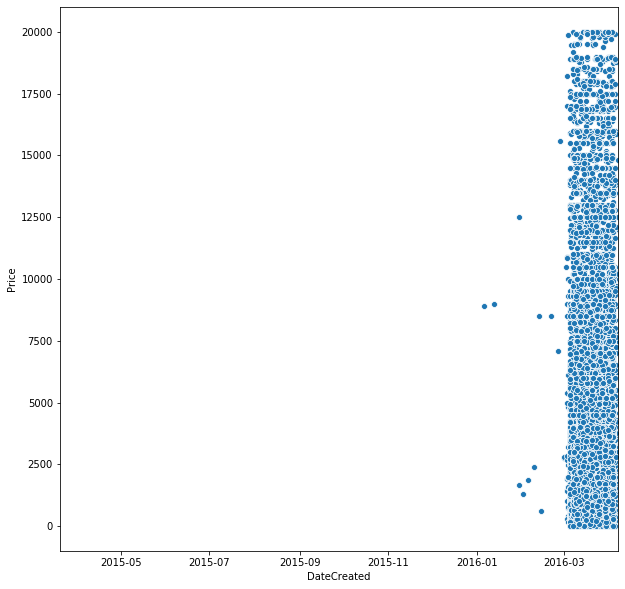

In [173]:
fig, ax = pyplot.subplots(figsize = (10,10))
# sns.jointplot(ax=ax,x='DateCrawled', y='Price', data=data.sample(10000))
sns.scatterplot(ax=ax,x='DateCreated', y='Price', data=data.sample(10000))
ax.set_xlim(data['DateCreated'].min(), data['DateCreated'].max())   

In [174]:
data['DateCreated'].describe()

count                  315403
unique                    106
top       2016-04-03 00:00:00
freq                    12277
first     2015-03-20 00:00:00
last      2016-04-07 00:00:00
Name: DateCreated, dtype: object

У нас в данных есть очень старые объявления. В задании звучит: "В нём можно быстро узнать рыночную стоимость своего автомобиля." Полагаю задача должна выполняться в контексте "адекватной цены". Старые объявления явно не будут отвечать этому критерию. 

In [175]:
from datetime import datetime
type
type(pd.to_datetime(1485714600, unit='s'))

pandas._libs.tslibs.timestamps.Timestamp

In [176]:
pd.to_timedelta(data.DateCreated).dt.total_seconds().describe()

/opt/conda/lib/python3.7/site-packages/pandas/util/_decorators.py:208: FutureWarning: Passing datetime64-dtype data to TimedeltaIndex is deprecated, will raise a TypeError in a future version
  return func(*args, **kwargs)


count    3.154030e+05
mean     1.458502e+09
std      8.039909e+05
min      1.426810e+09
25%      1.457827e+09
50%      1.458518e+09
75%      1.459210e+09
max      1.459987e+09
Name: DateCreated, dtype: float64

In [177]:
time_s = pd.to_timedelta(data.DateCreated).dt.total_seconds().describe()
Q25 = pd.to_timedelta(data.DateCreated).dt.total_seconds().describe()['25%']
Q25
Q75 = pd.to_timedelta(data.DateCreated).dt.total_seconds().describe()['75%']
Q75

1459209600.0

Переведем секунды обратно в дату.

In [178]:
timeQ25 = pd.to_datetime(Q25, unit='s', errors='coerce')
timeQ25

Timestamp('2016-03-13 00:00:00')

In [179]:
timeQ75 = pd.to_datetime(Q75, unit='s', errors='coerce')
timeQ75

Timestamp('2016-03-29 00:00:00')

In [180]:
left_time_boundary = timeQ25 - 1.5*(timeQ75 - timeQ25)
left_time_boundary = pd.to_datetime(left_time_boundary, unit='s', errors='coerce')
left_time_boundary

Timestamp('2016-02-18 00:00:00')

In [181]:
right_time_boundary = timeQ75 + 1.5*(timeQ75 - timeQ25)
right_time_boundary = pd.to_datetime(right_time_boundary, unit='s', errors='coerce')
right_time_boundary

Timestamp('2016-04-22 00:00:00')

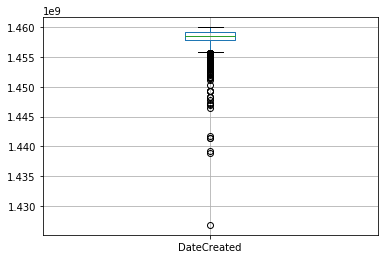

In [182]:
pd.DataFrame(pd.to_timedelta(data.DateCreated).dt.total_seconds()).boxplot()

Получили левую и правую границу для фильтрации выбросов по дате создания объявления.

In [183]:
data.shape

(315403, 13)

In [184]:
data.query('DateCreated < @right_time_boundary & DateCreated > @left_time_boundary').shape

(315206, 13)

In [185]:
data = data.query('DateCreated < @right_time_boundary & DateCreated > @left_time_boundary')

In [186]:
data

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,Expluatation
0,480,sedan,1993,manual,0,golf,150000,0,petrol,volkswagen,no,2016-03-24,23
2,9800,suv,2004,auto,163,grand,125000,8,petrol,jeep,no,2016-03-14,12
3,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17,15
4,3600,small,2008,manual,69,fabia,90000,7,petrol,skoda,no,2016-03-31,8
5,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes,2016-04-04,21
...,...,...,...,...,...,...,...,...,...,...,...,...,...
354363,1150,bus,2000,manual,0,zafira,150000,3,petrol,opel,no,2016-03-27,16
354364,0,sedan,2005,manual,0,colt,150000,7,petrol,mitsubishi,yes,2016-03-21,11
354366,1199,convertible,2000,auto,101,fortwo,125000,3,petrol,smart,no,2016-03-05,16
354367,9200,bus,1996,manual,102,transporter,150000,3,petrol,volkswagen,no,2016-03-19,20


(736013.0, 736061.0)

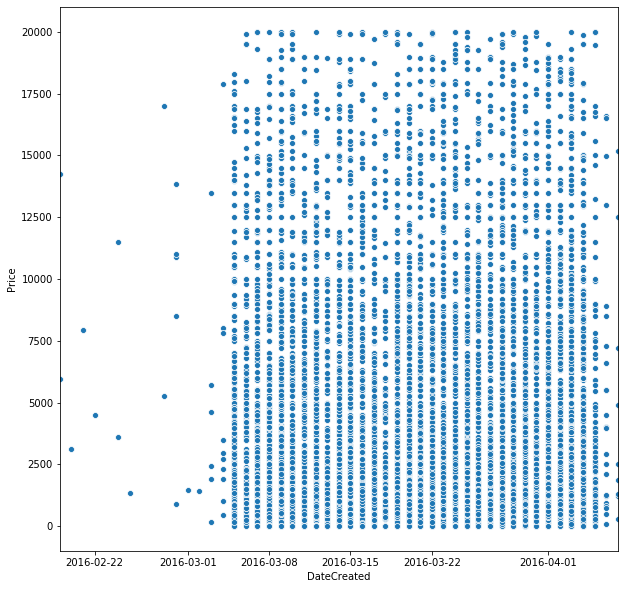

In [187]:
fig, ax = pyplot.subplots(figsize = (10,10))
# sns.jointplot(ax=ax,x='DateCrawled', y='Price', data=data.sample(10000))
sns.scatterplot(ax=ax,x='DateCreated', y='Price', data=data.sample(10000))
ax.set_xlim(data['DateCreated'].min(), data['DateCreated'].max())   

Учитывая оставшиеся данные по дате создания объявления можно сказать следующее: 
1. они упакованы практически в пределах одного месяца
2. Не имеет смысла искать корреляции между годом/месяцем и ценой
3. Можно добавить признаки дня недели. Но для пользователя будет выглядеть странным то, что ему в разные дни будут предлагать поставить за автомобиль разную цену. Это скорее вселит в пользователя системы сомнения в правдивости сервиса. Потому отбросим эту идею. 

Удалим параметр...

In [188]:
data.drop(columns = 'DateCreated',inplace = True)

/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


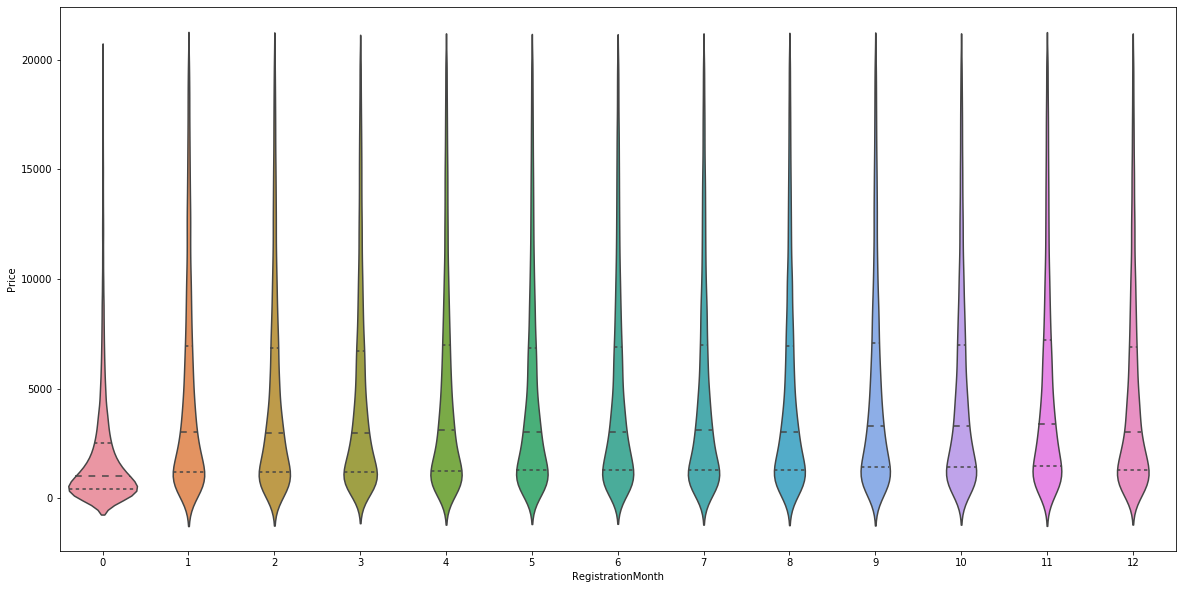

In [189]:
plt.figure(figsize=(20,10))
ax = sns.violinplot(data=data[['RegistrationMonth','Price']],x='RegistrationMonth',y='Price', inner="quartile")

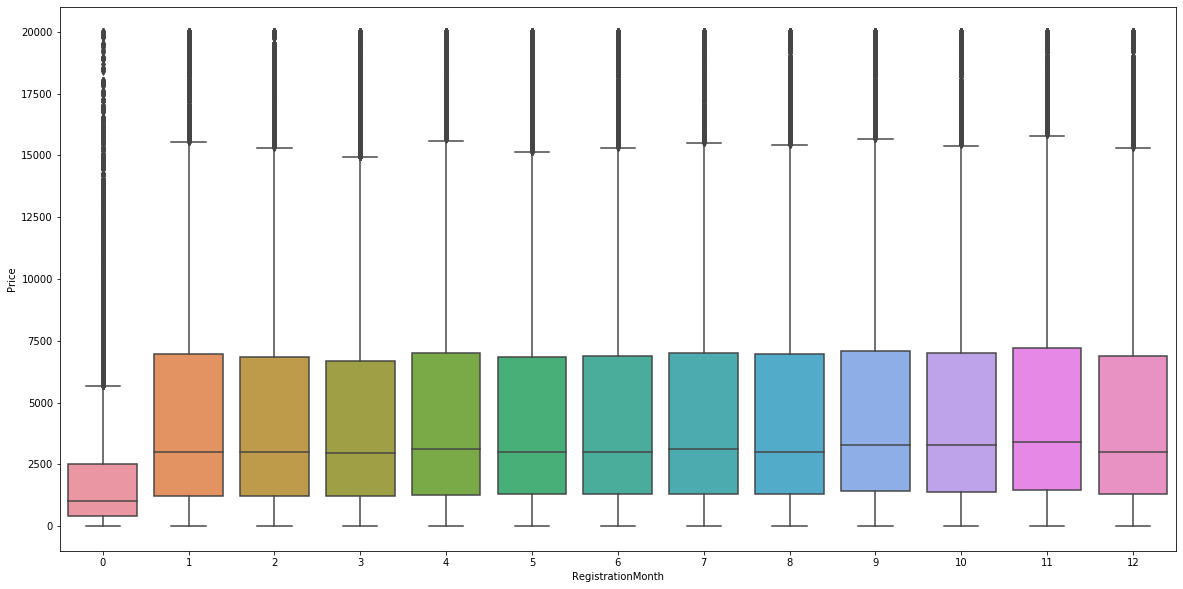

In [190]:
plt.figure(figsize=(20,10))
ax = sns.boxplot(data=data[['RegistrationMonth','Price']],x='RegistrationMonth',y='Price')

In [191]:
data[['RegistrationMonth','Price']].groupby('RegistrationMonth').describe()

Price                                                 \
                     count         mean          std  min     25%     50%   
RegistrationMonth                                                           
0                  23485.0  2057.502363  2826.124328  0.0   400.0  1000.0   
1                  21046.0  4770.532548  4694.187185  0.0  1200.0  2999.0   
2                  19662.0  4665.332723  4550.342201  0.0  1200.0  2990.0   
3                  31849.0  4657.520048  4577.112078  0.0  1200.0  2950.0   
4                  26920.0  4836.229792  4678.259800  0.0  1250.0  3100.0   
5                  26759.0  4717.626855  4566.071582  0.0  1299.0  3000.0   
6                  28824.0  4774.146891  4594.212504  0.0  1300.0  3000.0   
7                  24824.0  4793.109249  4601.625046  0.0  1299.0  3100.0   
8                  20867.0  4742.612977  4531.982725  0.0  1300.0  3000.0   
9                  22113.0  4943.541763  4645.191858  0.0  1400.0  3300.0   
10                 24168.0  4890.122145  4582.359312  0.0  1399.0  3299.0   
11                 22160.0  5026.430776  4709.363219  0.0  1450.0  3390.0   
12                 22529.0  4700.546496  4500.361073  0.0  1300.0  3000.0   

                                     
                       75%      max  
RegistrationMonth                    
0                  2500.00  20000.0  
1                  6950.00  20000.0  
2                  6850.00  20000.0  
3                  6700.00  20000.0  
4                  6999.00  20000.0  
5                  6850.00  20000.0  
6                  6900.00  20000.0  
7                  6990.00  20000.0  
8                  6950.00  20000.0  
9                  7100.00  20000.0  
10                 7000.00  20000.0  
11                 7199.25  20000.0  
12                 6900.00  20000.0

Серьезных колебаний цены не наблюдаю. 

### 1.4.2 [Численные признаки и цена](#Content)<a id='1.4.2'></a>

In [192]:
data.corr()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,Expluatation
Price,1.000000,0.565617,0.155113,-0.378874,0.083569,-0.565617
RegistrationYear,0.565617,1.000000,0.042199,-0.361125,0.038878,-1.000000
Power,0.155113,0.042199,1.000000,0.016190,0.025518,-0.042199
Kilometer,-0.378874,-0.361125,0.016190,1.000000,-0.018429,0.361125
RegistrationMonth,0.083569,0.038878,0.025518,-0.018429,1.000000,-0.038878
Expluatation,-0.565617,-1.000000,-0.042199,0.361125,-0.038878,1.000000


Удалим производный признак, который вводили для проверки адекватности дат **Expluatation**. Согласно коэффициенту корреляции вначале этой главы мы видим одинаковый вклад года регистрации авто и лет эксплуатации. 

In [193]:
data.drop(columns = 'Expluatation',inplace = True)

/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [194]:
data.select_dtypes(include='int64')

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth
0,480,1993,0,150000,0
2,9800,2004,163,125000,8
3,1500,2001,75,150000,6
4,3600,2008,69,90000,7
5,650,1995,102,150000,10
...,...,...,...,...,...
354363,1150,2000,0,150000,3
354364,0,2005,0,150000,7
354366,1199,2000,101,125000,3
354367,9200,1996,102,150000,3


In [195]:
data.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth
count,315206.000000,315206.000000,315206.000000,315206.000000,315206.000000
mean,4586.086781,2003.194406,115.250192,129164.784300,5.919446
std,4552.616613,5.725994,186.445422,36315.538857,3.634740
min,0.000000,1985.000000,0.000000,5000.000000,0.000000
25%,1200.000000,1999.000000,75.000000,125000.000000,3.000000
50%,2900.000000,2003.000000,105.000000,150000.000000,6.000000
75%,6600.000000,2007.000000,143.000000,150000.000000,9.000000
max,20000.000000,2016.000000,20000.000000,150000.000000,12.000000


In [196]:
data.RegistrationMonth.value_counts()

3     31849
6     28824
4     26920
5     26759
7     24824
10    24168
0     23485
12    22529
11    22160
9     22113
1     21046
8     20867
2     19662
Name: RegistrationMonth, dtype: int64

- Видим минимальные цены = 0. Такие значения надо удалять даже несмотря на то, что они в границах "усов". Автомобиль за такую цену может иметь проблемы, не отраженные в стандартной анкете и искажать предсказания. Верхняя граница цены вопросов не вызывает. 
- Месяц регистрации = 0 вызывает вопросы. Исправим равномерно распределив автомобили между оставшимися месяцами. 
- Мощность. Есть вопросы к верхней и нижней границе. Можно попробовать удалить или исправить. 
- Километраж вопросов не вызывает.
- Год регистрации вопросов не вызывает. Исправляли.

In [197]:
data = data.query('Price>500') #устранили проблемные цены

#### Месяц регистрации

In [198]:
import numpy as np

count_zeros = data.RegistrationMonth.value_counts()[0]

data.loc[data['RegistrationMonth']==0,'RegistrationMonth'] = np.random.randint(1,12,count_zeros)

/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [199]:
data.RegistrationMonth.value_counts()

3     30577
6     27904
4     26140
5     25945
7     24279
10    23890
11    22113
9     21945
8     20729
12    20707
1     20607
2     19221
Name: RegistrationMonth, dtype: int64

Проблема месяцев устранена

#### Мощность

In [200]:
data.query('15<=Power<20')

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired
4637,870,wagon,2000,manual,16,focus,150000,4,petrol,ford,no
12571,5999,small,2014,auto,15,other,10000,3,electric,renault,no
13227,5799,small,2013,auto,18,other,10000,6,electric,renault,no
29218,3300,wagon,2008,manual,15,fabia,150000,8,petrol,skoda,no
34218,1250,small,1993,manual,17,other,60000,3,petrol,fiat,yes
46374,2500,coupe,1993,manual,19,3er,150000,2,petrol,bmw,no
62026,5849,other,2012,auto,18,other,10000,1,electric,renault,no
84874,1500,wagon,1985,manual,19,601,10000,6,petrol,trabant,no
114041,2000,small,2007,manual,16,micra,150000,2,petrol,nissan,no
124276,19250,coupe,2011,manual,19,a5,70000,2,petrol,audi,yes


In [201]:
data.query('Brand=="skoda" & Model=="fabia"').Power.value_counts(normalize=True) 

75     0.238048
60     0.133964
86     0.088645
101    0.082669
69     0.075697
105    0.071215
0      0.055777
80     0.048805
54     0.041833
64     0.039841
68     0.022410
70     0.013944
90     0.012450
179    0.009960
116    0.009462
131    0.008466
110    0.006474
100    0.005976
55     0.004980
65     0.004482
50     0.003486
74     0.002988
58     0.001992
85     0.001992
180    0.001494
63     0.001494
107    0.000996
88     0.000996
120    0.000996
102    0.000996
59     0.000996
51     0.000498
47     0.000498
44     0.000498
15     0.000498
696    0.000498
82     0.000498
104    0.000498
114    0.000498
115    0.000498
118    0.000498
125    0.000498
130    0.000498
83     0.000498
Name: Power, dtype: float64

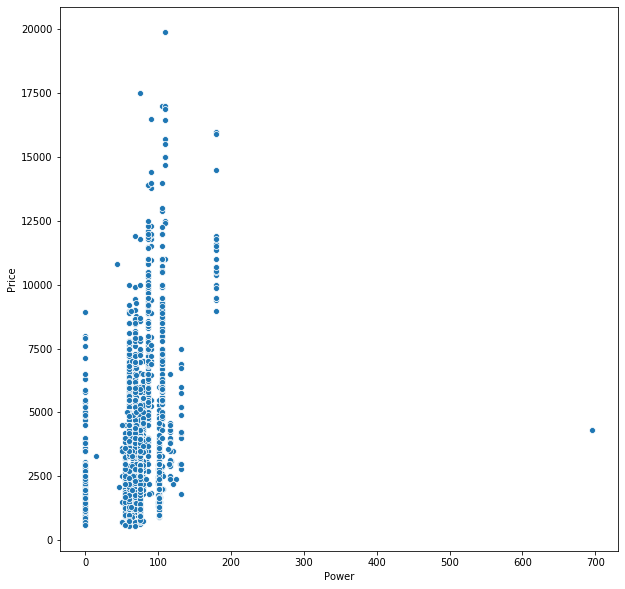

In [202]:
fig, ax = pyplot.subplots(figsize = (10,10))
# sns.jointplot(ax=ax,x='DateCrawled', y='Price', data=data.sample(10000))
sns.scatterplot(ax=ax,x='Power', y='Price', data=data.query('Brand=="skoda" & Model=="fabia"'))
  

In [203]:
data.query('Brand=="skoda" & Model=="fabia"').Power.describe()

count    2008.000000
mean       75.139442
std        29.921613
min         0.000000
25%        64.000000
50%        75.000000
75%        86.000000
max       696.000000
Name: Power, dtype: float64

Как видим, диапазон значений довольно широк. Я для себя вижу следующий диапазон для удаления-исправления ошибок: 
- Вне "усов". Размах выберу сам
- Нулевые значения.
    
Причины ошибки:
- Опечатки
- Незнание параметров авто

Вообще правильней всего будет удалить или заменить на наиболее часто встречающиеся значения. 
0.8% и ниже - удаляем. 

У нас будет 2 критерия отбора кандидатов на исправление-удаление:
- Как минимум должно быть 2 и более кандидата с одинаковой мощностью
- Пороговым значением из выборки. Я буду выбирать значения, занимающие > 0.5 % от общего количества
- Менее 20 л.с. (так вычеркнем и "0")

In [204]:
check = data.query('Power>20')#Brand=="skoda" & Model=="fabia" & 
check

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired
2,9800,suv,2004,auto,163,grand,125000,8,petrol,jeep,no
3,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,7,petrol,skoda,no
5,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes
6,2200,convertible,2004,manual,109,2_reihe,150000,8,petrol,peugeot,no
...,...,...,...,...,...,...,...,...,...,...,...
354361,5250,wagon,2016,auto,150,159,150000,12,petrol,alfa_romeo,no
354362,3200,sedan,2004,manual,225,leon,150000,5,petrol,seat,yes
354366,1199,convertible,2000,auto,101,fortwo,125000,3,petrol,smart,no
354367,9200,bus,1996,manual,102,transporter,150000,3,petrol,volkswagen,no


In [205]:
groupedPower = check.groupby(['Brand', 'Model','Power']).agg({'Power': 'count'})
# Группируем по мощности и делим на сумму 
power_pcts = groupedPower.groupby(level=1).apply(lambda x:
                                                 100 * x / float(x.sum()))
power_pcts.columns = ['PowerPercent']
power_pcts

PowerPercent
Brand      Model    Power              
alfa_romeo 145      90         4.347826
                    103       52.173913
                    120       26.086957
                    129        4.347826
                    140        4.347826
...                                 ...
volvo      xc_reihe 239        0.392157
                    267        0.392157
                    272        0.784314
                    286        0.392157
                    315        1.568627

[10083 rows x 1 columns]

In [206]:
groupedPower.columns = ['PowerCount']
groupedPower

PowerCount
Brand      Model    Power            
alfa_romeo 145      90              1
                    103            12
                    120             6
                    129             1
                    140             1
...                               ...
volvo      xc_reihe 239             1
                    267             1
                    272             2
                    286             1
                    315             4

[10083 rows x 1 columns]

In [207]:
groupedPower = groupedPower.merge(power_pcts,left_index = True, right_index=True)

In [208]:
groupedPower

PowerCount  PowerPercent
Brand      Model    Power                          
alfa_romeo 145      90              1      4.347826
                    103            12     52.173913
                    120             6     26.086957
                    129             1      4.347826
                    140             1      4.347826
...                               ...           ...
volvo      xc_reihe 239             1      0.392157
                    267             1      0.392157
                    272             2      0.784314
                    286             1      0.392157
                    315             4      1.568627

[10083 rows x 2 columns]

Теперь наша задача убрать лишние значения, но не слишком много. 

Принцип такой:
- Автомобилей с данной мощностью < 1% от общего количества (сгруппированных по марке + модели)
- Автомобилей <3

In [209]:
def removed_rows(row):
    remove = 0
    if ((row['PowerCount'] < 3) & (row['PowerPercent'] < 1)):
        remove = 1
    return remove

In [210]:
groupedPower['Remove'] = groupedPower.apply(removed_rows,axis = 1)

In [211]:
groupedPower.query('Brand=="skoda" & Model == "fabia"')

PowerCount  PowerPercent  Remove
Brand Model Power                                  
skoda fabia 44              1      0.052770       1
            47              1      0.052770       1
            50              7      0.369393       0
            51              1      0.052770       1
            54             84      4.432718       0
            55             10      0.527704       0
            58              4      0.211082       0
            59              2      0.105541       1
            60            269     14.195251       0
            63              3      0.158311       0
            64             80      4.221636       0
            65              9      0.474934       0
            68             45      2.374670       0
            69            152      8.021108       0
            70             28      1.477573       0
            74              6      0.316623       0
            75            478     25.224274       0
            80             98      5.171504       0
            82              1      0.052770       1
            83              1      0.052770       1
            85              4      0.211082       0
            86            178      9.393140       0
            88              2      0.105541       1
            90             25      1.319261       0
            100            12      0.633245       0
            101           166      8.759894       0
            102             2      0.105541       1
            104             1      0.052770       1
            105           143      7.546174       0
            107             2      0.105541       1
            110            13      0.686016       0
            114             1      0.052770       1
            115             1      0.052770       1
            116            19      1.002639       0
            118             1      0.052770       1
            120             2      0.105541       1
            125             1      0.052770       1
            130             1      0.052770       1
            131            17      0.897098       0
            179            20      1.055409       0
            180             3      0.158311       0
            696             1      0.052770       1

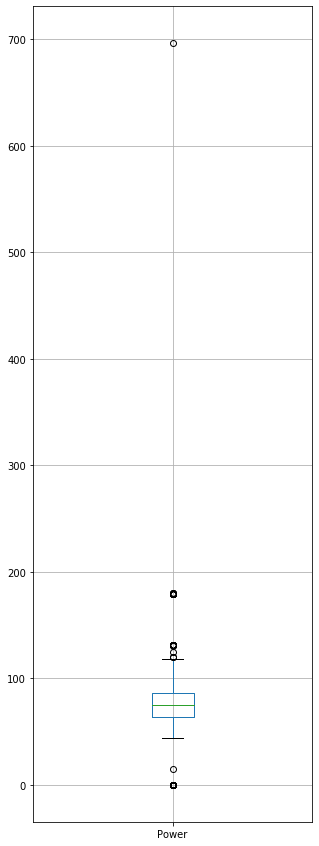

In [212]:
pd.DataFrame(data.query('Brand=="skoda" & Model == "fabia"')['Power']).boxplot(figsize = (5,15))

In [213]:
groupedPower.query('Brand=="skoda" & Model == "fabia"').sum()

PowerCount      1895.0
PowerPercent     100.0
Remove            17.0
dtype: float64

Видим число удаляемых значений: 17. Доля = 17/1906 ~ 1%

In [214]:
check.query('Brand=="skoda" & Model == "fabia"')

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired
4,3600,small,2008,manual,69,fabia,90000,7,petrol,skoda,no
62,5500,small,2010,manual,60,fabia,70000,4,petrol,skoda,no
132,6990,wagon,2012,manual,75,fabia,100000,5,petrol,skoda,no
179,16449,wagon,2015,auto,110,fabia,10000,8,petrol,skoda,no
181,3000,small,2016,auto,75,fabia,150000,9,petrol,skoda,no
...,...,...,...,...,...,...,...,...,...,...,...
353621,2000,small,2002,manual,101,fabia,150000,6,petrol,skoda,no
353654,11900,small,2015,manual,69,fabia,30000,2,petrol,skoda,no
353952,3950,wagon,2003,manual,75,fabia,50000,2,petrol,skoda,no
354161,5400,small,2008,manual,86,fabia,60000,9,petrol,skoda,no


Процентные соотношения найдены. Теперь назначим аутсайдеров! 

In [215]:
check = check.merge(groupedPower,left_on = ['Brand','Model','Power'], right_on=['Brand','Model','Power'])
check

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,PowerCount,PowerPercent,Remove
0,9800,suv,2004,auto,163,grand,125000,8,petrol,jeep,no,38,7.465619,0
1,9000,suv,2003,auto,163,grand,90000,9,petrol,jeep,no,38,7.465619,0
2,7800,suv,2003,auto,163,grand,150000,11,petrol,jeep,no,38,7.465619,0
3,6600,suv,2004,auto,163,grand,150000,3,petrol,jeep,no,38,7.465619,0
4,6990,suv,2003,auto,163,grand,150000,11,petrol,jeep,no,38,7.465619,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
266729,2999,other,1989,manual,45,transporter,150000,11,petrol,volkswagen,no,1,0.024869,1
266730,600,wagon,2000,manual,103,primera,150000,1,petrol,nissan,yes,1,0.217865,1
266731,1650,coupe,1999,manual,177,other,150000,8,petrol,ford,yes,1,0.005741,1
266732,1650,bus,2002,manual,66,vito,150000,2,petrol,mercedes_benz,no,1,0.136240,1


In [216]:
check.Remove.sum()

6007

In [217]:
check.query('Remove==0 & Power>500')

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,PowerCount,PowerPercent,Remove
235876,18500,small,2002,auto,600,s_type,150000,12,petrol,jaguar,no,3,2.608696,0
235877,12500,sedan,2002,auto,600,s_type,150000,12,petrol,jaguar,no,3,2.608696,0
235878,12000,sedan,2002,auto,600,s_type,150000,12,petrol,jaguar,no,3,2.608696,0
240919,15500,coupe,2009,auto,507,m_reihe,150000,1,petrol,bmw,yes,9,8.571429,0
240920,20000,sedan,2006,auto,507,m_reihe,150000,6,petrol,bmw,no,9,8.571429,0
240921,20000,sedan,2006,auto,507,m_reihe,150000,6,petrol,bmw,no,9,8.571429,0
240922,8999,sedan,2006,auto,507,m_reihe,100000,1,petrol,bmw,yes,9,8.571429,0
240923,15500,coupe,2009,auto,507,m_reihe,150000,1,petrol,bmw,yes,9,8.571429,0
240924,2500,coupe,2005,auto,507,m_reihe,125000,12,petrol,bmw,yes,9,8.571429,0
240925,15500,coupe,2009,auto,507,m_reihe,150000,1,petrol,bmw,yes,9,8.571429,0


Замечательные фильтры пропустили всего несколько косяков, и все они больше 1000 лошадей. Просто удалим их/

In [218]:
data = check.query('Remove==0 & Power<1000').drop(columns=['PowerCount','PowerPercent','Remove'], axis = 1)

In [219]:
data.query('Power > 1000')

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired


Все супер!

## 1.5 [Приведение типов](#Content)<a id='1.5'></a>

In [220]:
data.dtypes

Price                 int64
VehicleType          object
RegistrationYear      int64
Gearbox              object
Power                 int64
Model                object
Kilometer             int64
RegistrationMonth     int64
FuelType             object
Brand                object
NotRepaired          object
dtype: object

In [221]:
def downcast_floats(df,downcast_type):
    for col_name in data.select_dtypes(include=[downcast_type]).columns:
        df[col_name] = pd.to_numeric(df[col_name], downcast = 'integer')
    return df

In [222]:
downcast_floats(data,'int64')
data.dtypes

Price                 int16
VehicleType          object
RegistrationYear      int16
Gearbox              object
Power                 int16
Model                object
Kilometer             int32
RegistrationMonth      int8
FuelType             object
Brand                object
NotRepaired          object
dtype: object

Численные типы приведены

# 2. [Обучение моделей](#Content)<a id='2'></a>

Импортируем библиотеки

In [223]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

Делим на выборки. Обучающую и тестовую.

In [224]:
categories_columns = ['VehicleType','Gearbox','Model','FuelType','Brand','NotRepaired']
data[categories_columns] = data[categories_columns].astype('category')

In [225]:
data.dtypes

Price                   int16
VehicleType          category
RegistrationYear        int16
Gearbox              category
Power                   int16
Model                category
Kilometer               int32
RegistrationMonth        int8
FuelType             category
Brand                category
NotRepaired          category
dtype: object

In [226]:
train, other = train_test_split(data,test_size = 0.3 ,random_state = 42)

In [227]:
valid, test = train_test_split(other,test_size = 0.5 ,random_state = 42)

In [228]:
train.shape

(182504, 11)

In [229]:
test.shape

(39108, 11)

## 2.1 [Подготовка признаков](#Content)<a id='2.1'></a>

Масштабируем признаки

In [230]:
data.dtypes

Price                   int16
VehicleType          category
RegistrationYear        int16
Gearbox              category
Power                   int16
Model                category
Kilometer               int32
RegistrationMonth        int8
FuelType             category
Brand                category
NotRepaired          category
dtype: object

In [231]:
numeric_data_col = ['Kilometer','Power','RegistrationYear','RegistrationMonth']

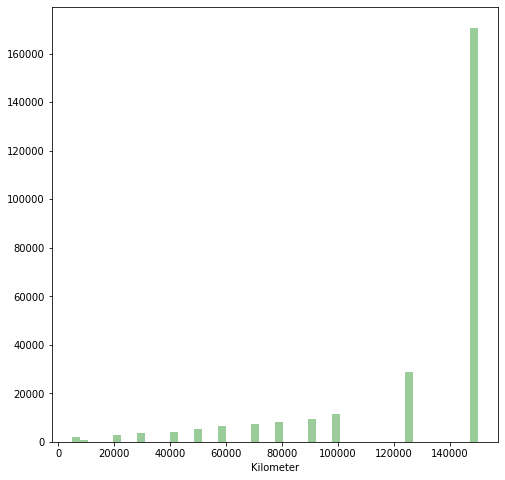

In [232]:
fig, ax = pyplot.subplots(figsize = (8,8))
sns.distplot(data[numeric_data_col[0]], hist=True, kde=False, color="g", kde_kws={"shade": True},ax=ax)

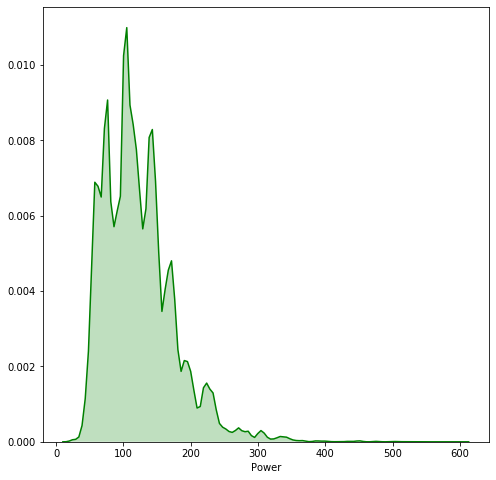

In [233]:
fig, ax = pyplot.subplots(figsize = (8,8))
sns.distplot(data[numeric_data_col[1]], hist=False, color="g", kde_kws={"shade": True},ax=ax)

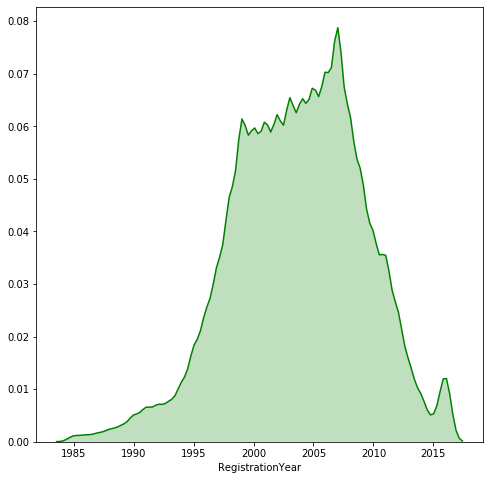

In [234]:
fig, ax = pyplot.subplots(figsize = (8,8))
sns.distplot(data[numeric_data_col[2]], hist=False, color="g", kde_kws={"shade": True},ax=ax)

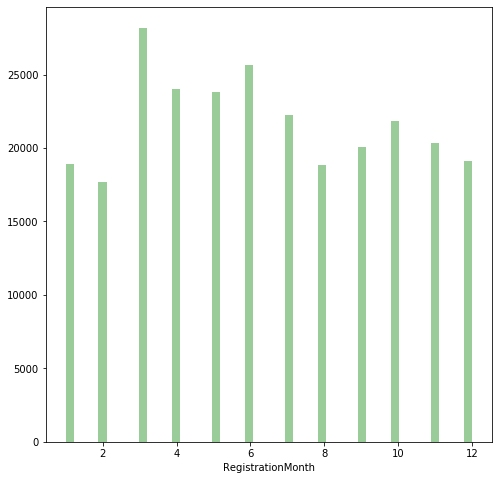

In [235]:
fig, ax = pyplot.subplots(figsize = (8,8))
sns.distplot(data[numeric_data_col[3]], hist=True, kde=False, color="g", kde_kws={"shade": True},ax=ax)

Численные признаки рассмотрены. Осталось их отмасштабировать. 

In [236]:
from sklearn.preprocessing import StandardScaler

In [237]:
st_scaler = StandardScaler()

In [238]:
st_scaler.fit(train[numeric_data_col])

StandardScaler(copy=True, with_mean=True, with_std=True)

In [239]:
train.loc[:,numeric_data_col] = st_scaler.transform(train[numeric_data_col])
valid.loc[:,numeric_data_col] = st_scaler.transform(valid[numeric_data_col])
test.loc[:,numeric_data_col] = st_scaler.transform(test[numeric_data_col])

/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the document

In [240]:
train

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired
188621,18000,sedan,1.705258,manual,-0.248700,qashqai,-2.688341,0.183233,petrol,nissan,no
102237,3500,wagon,1.338508,manual,0.710243,insignia,-1.042310,1.379151,petrol,opel,yes
33516,12500,convertible,0.605009,manual,0.767779,a4,0.603721,1.080171,petrol,audi,no
35557,12900,sedan,0.605009,auto,2.148657,5er,0.603721,1.678130,petrol,bmw,no
34400,4200,wagon,0.054885,manual,-0.421309,passat,0.603721,-0.115746,petrol,volkswagen,no
...,...,...,...,...,...,...,...,...,...,...,...
261905,1890,sedan,-0.495240,auto,0.365024,s60,0.603721,0.781192,petrol,volvo,no
103706,6600,sedan,0.054885,auto,0.767779,c_klasse,0.603721,-0.713705,petrol,mercedes_benz,no
131951,2950,small,0.421634,manual,-1.111748,picanto,-1.590987,0.781192,petrol,kia,no
146892,6800,small,1.705258,manual,-1.207642,up,-2.688341,1.678130,petrol,volkswagen,no


## 2.2 [Подбор оптимальных гиперпараметров](#Content)<a id='2.2'></a>

Цитата из задания:

Заказчику важны:
- качество предсказания;
- скорость предсказания;
- время обучения.

Примечания:
- Для оценки качества моделей применяйте метрику RMSE.
- Самостоятельно освойте библиотеку LightGBM и её средствами постройте модели градиентного бустинга.
- Время выполнения ячейки кода Jupyter Notebook можно получить специальной командой. Найдите её.
- Поскольку модель градиентного бустинга может обучаться долго, измените у неё только два-три параметра.

Соответственно **мой подход** к работе с моделью:
1. Изучаю библиотеку LightGMB. Методы перебора параметров. 
2. Выбираю гиперпараметры для "варьирования"
3. Ищу минимальную RMSE с учетом проварьированных гиперпараметров (*оценка качества предсказания*). Желаемая оценка не определена. Принцип - найти минимум и представить его "заказчику"
4. Обучаю модель с Таймингом не более 10-15 минут (*время обучения*)
5. Прогоняю на предикте обучающую и валидационную выборку с таймингом (*время предсказания*)... 
6. Выводы

### 2.2.1 [LightGMB модель](#Content)<a id='2.2.1'></a>

Читаем инструкцию и рекомендации:
https://lightgbm.readthedocs.io/en/latest/Parameters-Tuning.html#tune-parameters-for-the-leaf-wise-best-first-tree

Первые три параметра, которые сильно влияют на качество модели:
**num_leaves** - число листьев в дереве для контроля модели дерева. Говорится о теоретическом числе листьев 2^(max_depth). Данный параметр скорее отвечает за контроль оптимального соотношения между числом листьев и глубиной

This is the main parameter to control the complexity of the tree model. Theoretically, we can set num_leaves = 2^(max_depth) to obtain the same number of leaves as depth-wise tree. However, this simple conversion is not good in practice. The reason is that a leaf-wise tree is typically much deeper than a depth-wise tree for a fixed number of leaves. Unconstrained depth can induce over-fitting. Thus, when trying to tune the num_leaves, we should let it be smaller than 2^(max_depth). For example, when the max_depth=7 the depth-wise tree can get good accuracy, but setting num_leaves to 127 may cause over-fitting, and setting it to 70 or 80 may get better accuracy than depth-wise.

**min_data_in_leaf**. Пишут про его важность c точки зрения переобучения. Оптимальное значение зависит от набора тренировочных данных (размер?) и числа листьев в на нижнем уровне дерева. Контролирует переобучение. Большое значение позволяет избежать построения слишком глубокого дерева и переобучения. На практике имеет смысл делать его равным тысячам и сотням для больших датасетов

This is a very important parameter to prevent over-fitting in a leaf-wise tree. Its optimal value depends on the number of training samples and num_leaves. Setting it to a large value can avoid growing too deep a tree, but may cause under-fitting. In practice, setting it to hundreds or thousands is enough for a large dataset.

**max_depth**. Его тоже можно настроить. 

You also can use max_depth to limit the tree depth explicitly.

In [261]:
# import lightgbm as lgb
# from catboost import Pool, CatBoostRegressor
from lightgbm.sklearn import LGBMRegressor

Проба пера

In [281]:
LGBMReg1 = LGBMRegressor(random_state = 12345, max_depth = 10, n_estimators = 50, metric = 'rmse')

In [282]:
%%time
LGBMReg1.fit(train.drop(columns = 'Price'), train['Price'], categorical_feature = categories_columns)

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1295: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['Brand', 'FuelType', 'Gearbox', 'Model', 'NotRepaired', 'VehicleType']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


CPU times: user 4.49 s, sys: 26.5 ms, total: 4.52 s
Wall time: 4.57 s


LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=10,
              metric='rmse', min_child_samples=20, min_child_weight=0.001,
              min_split_gain=0.0, n_estimators=50, n_jobs=-1, num_leaves=31,
              objective=None, random_state=12345, reg_alpha=0.0, reg_lambda=0.0,
              silent=True, subsample=1.0, subsample_for_bin=200000,
              subsample_freq=0)

In [283]:
mean_squared_error(LGBMReg1.predict(valid.drop(columns = 'Price')),valid['Price']) ** 0.5

1665.9972904766878

In [284]:
LGBMReg2 = LGBMRegressor(random_state = 12345, max_depth = 10, n_estimators = 100, num_leaves = 120, metric = 'rmse')

In [285]:
%%time
LGBMReg2.fit(train.drop(columns = 'Price'), train['Price'], categorical_feature = categories_columns)

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1295: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['Brand', 'FuelType', 'Gearbox', 'Model', 'NotRepaired', 'VehicleType']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


CPU times: user 11.7 s, sys: 55.1 ms, total: 11.7 s
Wall time: 11.8 s


LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=10,
              metric='rmse', min_child_samples=20, min_child_weight=0.001,
              min_split_gain=0.0, n_estimators=100, n_jobs=-1, num_leaves=120,
              objective=None, random_state=12345, reg_alpha=0.0, reg_lambda=0.0,
              silent=True, subsample=1.0, subsample_for_bin=200000,
              subsample_freq=0)

In [286]:
mean_squared_error(LGBMReg2.predict(valid.drop(columns = 'Price')),valid['Price']) ** 0.5

1557.1641818010917

In [287]:
LGBMReg3 = LGBMRegressor(random_state = 12345, max_depth = 10, n_estimators = 100, num_leaves = 240, metric = 'rmse')

In [288]:
%%time
LGBMReg3.fit(train.drop(columns = 'Price'), train['Price'], categorical_feature = categories_columns)

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1295: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['Brand', 'FuelType', 'Gearbox', 'Model', 'NotRepaired', 'VehicleType']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


CPU times: user 15.9 s, sys: 158 ms, total: 16.1 s
Wall time: 16.2 s


LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=10,
              metric='rmse', min_child_samples=20, min_child_weight=0.001,
              min_split_gain=0.0, n_estimators=100, n_jobs=-1, num_leaves=240,
              objective=None, random_state=12345, reg_alpha=0.0, reg_lambda=0.0,
              silent=True, subsample=1.0, subsample_for_bin=200000,
              subsample_freq=0)

In [289]:
mean_squared_error(LGBMReg3.predict(valid.drop(columns = 'Price')),valid['Price']) ** 0.5

1535.234638974108

**Промежуточный вывод LGBMRegressor**: 
1. Число листьев определенно положительно влияет на точность и не замедляет модель. Эффект от увеличения числа листьев быстро затухает.
2. Повышаем дальше точность. 1500+ евро - явно мимо... 

Читаем рекомендации: https://lightgbm.readthedocs.io/en/latest/Parameters-Tuning.html#for-better-accuracy

For Better Accuracy
- Use large max_bin (may be slower) 

- Use small learning_rate with large num_iterations

- Use large num_leaves (may cause over-fitting)

- Use bigger training data

- Try dart

learning_rate 🔗︎, default = 0.1, type = double, aliases: shrinkage_rate, eta, constraints: learning_rate > 0.0

shrinkage rate

in dart, it also affects on normalization weights of dropped trees

num_iterations 🔗︎, default = 100, type = int, aliases: num_iteration, n_iter, num_tree, num_trees, num_round, num_rounds, num_boost_round, n_estimators, constraints: num_iterations >= 0

number of boosting iterations

Note: internally, LightGBM constructs num_class * num_iterations trees for multi-class classification problems

In [290]:
LGBMReg4 = LGBMRegressor(random_state = 12345, max_depth = 10, n_estimators = 100, num_leaves = 240, max_bin = 511, metric = 'rmse')

In [291]:
%%time
LGBMReg4.fit(train.drop(columns = 'Price'), train['Price'], categorical_feature = categories_columns)

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1295: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['Brand', 'FuelType', 'Gearbox', 'Model', 'NotRepaired', 'VehicleType']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


CPU times: user 16.2 s, sys: 123 ms, total: 16.3 s
Wall time: 16.5 s


LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_bin=511,
              max_depth=10, metric='rmse', min_child_samples=20,
              min_child_weight=0.001, min_split_gain=0.0, n_estimators=100,
              n_jobs=-1, num_leaves=240, objective=None, random_state=12345,
              reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=1.0,
              subsample_for_bin=200000, subsample_freq=0)

In [292]:
mean_squared_error(LGBMReg4.predict(valid.drop(columns = 'Price')),valid['Price']) ** 0.5

1537.7967208935454

In [293]:
LGBMReg5 = LGBMRegressor(random_state = 12345, 
                         num_iterations = 200, 
                         max_depth = 10, 
                         n_estimators = 100, 
                         num_leaves = 240, 
                         metric = 'rmse',
                         learning_rate = 0.05)

In [294]:
%%time
LGBMReg5.fit(train.drop(columns = 'Price'), train['Price'], categorical_feature = categories_columns)

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1295: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['Brand', 'FuelType', 'Gearbox', 'Model', 'NotRepaired', 'VehicleType']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


CPU times: user 54.7 s, sys: 252 ms, total: 54.9 s
Wall time: 56.3 s


LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.05, max_depth=10,
              metric='rmse', min_child_samples=20, min_child_weight=0.001,
              min_split_gain=0.0, n_estimators=100, n_jobs=-1,
              num_iterations=200, num_leaves=240, objective=None,
              random_state=12345, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [295]:
mean_squared_error(LGBMReg5.predict(valid.drop(columns = 'Price')),valid['Price']) ** 0.5

1532.3268973233492

In [296]:
LGBMReg6 = LGBMRegressor(random_state = 12345, 
                         num_iterations = 300, 
                         max_depth = 20, 
                         n_estimators = 200, 
                         num_leaves = 240, 
                         metric = 'rmse')

In [297]:
%%time
LGBMReg6.fit(train.drop(columns = 'Price'), train['Price'], categorical_feature = categories_columns)

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1295: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['Brand', 'FuelType', 'Gearbox', 'Model', 'NotRepaired', 'VehicleType']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


CPU times: user 48.3 s, sys: 389 ms, total: 48.7 s
Wall time: 49.1 s


LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=20,
              metric='rmse', min_child_samples=20, min_child_weight=0.001,
              min_split_gain=0.0, n_estimators=200, n_jobs=-1,
              num_iterations=300, num_leaves=240, objective=None,
              random_state=12345, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [298]:
mean_squared_error(LGBMReg6.predict(valid.drop(columns = 'Price')),valid['Price']) ** 0.5

1491.5816902752335

In [262]:
LGBMReg7 = LGBMRegressor(random_state = 12345, 
                         max_depth = 40, 
                         n_estimators = 200, 
                         num_leaves = 240, 
                         metric = 'rmse')

In [263]:
%%time
LGBMReg7.fit(train.drop(columns = 'Price'), train['Price'], categorical_feature = categories_columns)

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1295: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['Brand', 'FuelType', 'Gearbox', 'Model', 'NotRepaired', 'VehicleType']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


CPU times: user 30.3 s, sys: 338 ms, total: 30.6 s
Wall time: 31.1 s


LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=40,
              metric='rmse', min_child_samples=20, min_child_weight=0.001,
              min_split_gain=0.0, n_estimators=200, n_jobs=-1, num_leaves=240,
              objective=None, random_state=12345, reg_alpha=0.0, reg_lambda=0.0,
              silent=True, subsample=1.0, subsample_for_bin=200000,
              subsample_freq=0)

In [264]:
mean_squared_error(LGBMReg7.predict(valid.drop(columns = 'Price')),valid['Price']) ** 0.5

1495.1898725510346

Пока остановимся: RMSE чуть меньше 1500 евро. Не очень понимаю, как выжать больше не вылизывая алгоритм. Может проблема в исходных данных. 

### 2.2.2 [CatBoost модель](#Content)<a id='2.2.2'></a>

In [241]:
from catboost import CatBoostRegressor

Буду тестировать те базовые параметры, которые указываются для регрессора на страничке саппорта:
https://catboost.ai/docs/concepts/python-quickstart.html

In [242]:
%%time
# specify the training parameters 
CatBoostReg1 = CatBoostRegressor(iterations=50, 
                                 depth=8, 
                                 learning_rate=1, 
                                 loss_function='RMSE')
#train the model
CatBoostReg1.fit(train.drop(columns = 'Price'), train['Price'], cat_features=categories_columns, verbose=2)

0:	learn: 2484.4161416	total: 420ms	remaining: 20.6s
2:	learn: 2053.2952446	total: 1.13s	remaining: 17.6s
4:	learn: 1941.9898074	total: 1.82s	remaining: 16.4s
6:	learn: 1853.5178277	total: 2.43s	remaining: 14.9s
8:	learn: 1820.6089196	total: 3.12s	remaining: 14.2s
10:	learn: 1794.5565950	total: 3.73s	remaining: 13.2s
12:	learn: 1771.0092523	total: 4.42s	remaining: 12.6s
14:	learn: 1748.3716345	total: 5.12s	remaining: 11.9s
16:	learn: 1729.1301443	total: 5.81s	remaining: 11.3s
18:	learn: 1717.9517887	total: 6.4s	remaining: 10.4s
20:	learn: 1703.5563064	total: 7.08s	remaining: 9.78s
22:	learn: 1693.0390038	total: 7.7s	remaining: 9.04s
24:	learn: 1681.6727703	total: 8.39s	remaining: 8.39s
26:	learn: 1669.1033846	total: 9.08s	remaining: 7.74s
28:	learn: 1661.4164270	total: 9.69s	remaining: 7.01s
30:	learn: 1653.8068422	total: 10.4s	remaining: 6.36s
32:	learn: 1645.0233781	total: 11s	remaining: 5.66s
34:	learn: 1638.2205173	total: 11.7s	remaining: 5s
36:	learn: 1633.7159661	total: 12.3s	rem

In [243]:
CatBoostReg1.get_best_score()

{'learn': {'RMSE': 1599.0622201811705}}

In [244]:
mean_squared_error(CatBoostReg1.predict(valid.drop(columns = 'Price')),valid['Price']) ** 0.5

1674.0790270406196

In [245]:
%%time
# specify the training parameters 
CatBoostReg2 = CatBoostRegressor(iterations=50, 
                                 depth=8, 
                                  
                                 loss_function='RMSE')
#train the model
CatBoostReg2.fit(train.drop(columns = 'Price'), train['Price'], cat_features=categories_columns, verbose=2)

0:	learn: 4484.2853765	total: 290ms	remaining: 14.2s
2:	learn: 4301.4284192	total: 991ms	remaining: 15.5s
4:	learn: 4130.6126113	total: 1.69s	remaining: 15.2s
6:	learn: 3971.3661836	total: 2.38s	remaining: 14.6s
8:	learn: 3825.4998433	total: 3.09s	remaining: 14.1s
10:	learn: 3688.6515079	total: 3.78s	remaining: 13.4s
12:	learn: 3558.8550407	total: 4.4s	remaining: 12.5s
14:	learn: 3440.7053950	total: 5.08s	remaining: 11.9s
16:	learn: 3331.4800322	total: 5.78s	remaining: 11.2s
18:	learn: 3227.6666742	total: 6.48s	remaining: 10.6s
20:	learn: 3130.9274615	total: 7.17s	remaining: 9.9s
22:	learn: 3041.3036744	total: 7.78s	remaining: 9.13s
24:	learn: 2959.8425674	total: 8.47s	remaining: 8.47s
26:	learn: 2883.8687058	total: 9.07s	remaining: 7.73s
28:	learn: 2814.1983888	total: 9.77s	remaining: 7.07s
30:	learn: 2749.6951561	total: 10.4s	remaining: 6.36s
32:	learn: 2691.5935305	total: 11.1s	remaining: 5.7s
34:	learn: 2636.5016623	total: 11.7s	remaining: 5s
36:	learn: 2577.8524037	total: 12.4s	re

In [246]:
mean_squared_error(CatBoostReg2.predict(valid.drop(columns = 'Price')),valid['Price']) ** 0.5

2312.3199594747102

In [247]:
%%time
# specify the training parameters 
CatBoostReg3 = CatBoostRegressor(iterations=50, 
                                 depth=8, 
                                 learning_rate=0.5,  
                                 loss_function='RMSE')
#train the model
CatBoostReg3.fit(train.drop(columns = 'Price'), train['Price'], cat_features=categories_columns, verbose=2)

0:	learn: 3144.0019555	total: 232ms	remaining: 11.4s
2:	learn: 2164.9873746	total: 1.03s	remaining: 16.2s
4:	learn: 1965.6455276	total: 1.72s	remaining: 15.5s
6:	learn: 1881.4015337	total: 2.33s	remaining: 14.3s
8:	learn: 1848.1620339	total: 3.02s	remaining: 13.8s
10:	learn: 1810.9096281	total: 3.72s	remaining: 13.2s
12:	learn: 1788.2770720	total: 4.32s	remaining: 12.3s
14:	learn: 1772.5055039	total: 4.92s	remaining: 11.5s
16:	learn: 1754.1417963	total: 5.62s	remaining: 10.9s
18:	learn: 1739.1366179	total: 6.31s	remaining: 10.3s
20:	learn: 1727.2315379	total: 6.91s	remaining: 9.55s
22:	learn: 1714.3730575	total: 7.51s	remaining: 8.82s
24:	learn: 1701.6023509	total: 8.21s	remaining: 8.21s
26:	learn: 1692.3253334	total: 8.81s	remaining: 7.51s
28:	learn: 1685.5110425	total: 9.51s	remaining: 6.88s
30:	learn: 1676.3982504	total: 10.2s	remaining: 6.25s
32:	learn: 1666.5731750	total: 10.8s	remaining: 5.57s
34:	learn: 1660.4536032	total: 11.5s	remaining: 4.93s
36:	learn: 1654.0939938	total: 12

In [248]:
mean_squared_error(CatBoostReg3.predict(valid.drop(columns = 'Price')),valid['Price']) ** 0.5

1663.3559913076656

In [249]:
%%time
# specify the training parameters 
CatBoostReg4 = CatBoostRegressor(iterations=50, 
                                 depth=12, 
                                 learning_rate=0.5,  
                                 loss_function='RMSE')
#train the model
CatBoostReg4.fit(train.drop(columns = 'Price'), train['Price'], cat_features=categories_columns, verbose=2)

0:	learn: 3002.2075001	total: 531ms	remaining: 26s
2:	learn: 2059.1722494	total: 1.72s	remaining: 27s
4:	learn: 1837.5697436	total: 2.81s	remaining: 25.3s
6:	learn: 1751.0739490	total: 3.82s	remaining: 23.5s
8:	learn: 1713.9959294	total: 4.92s	remaining: 22.4s
10:	learn: 1688.2252609	total: 5.91s	remaining: 21s
12:	learn: 1664.2952784	total: 7s	remaining: 19.9s
14:	learn: 1639.9041917	total: 8.01s	remaining: 18.7s
16:	learn: 1621.7693566	total: 9.1s	remaining: 17.7s
18:	learn: 1604.4717058	total: 10.1s	remaining: 16.5s
20:	learn: 1589.0544427	total: 11.2s	remaining: 15.5s
22:	learn: 1574.0834116	total: 12.2s	remaining: 14.3s
24:	learn: 1562.3911857	total: 13.3s	remaining: 13.3s
26:	learn: 1551.5050032	total: 14.3s	remaining: 12.2s
28:	learn: 1540.2050652	total: 15.4s	remaining: 11.2s
30:	learn: 1528.0418125	total: 16.5s	remaining: 10.1s
32:	learn: 1521.8120049	total: 17.6s	remaining: 9.06s
34:	learn: 1510.0605442	total: 18.7s	remaining: 8.01s
36:	learn: 1497.2799692	total: 19.8s	remain

In [250]:
mean_squared_error(CatBoostReg4.predict(valid.drop(columns = 'Price')),valid['Price']) ** 0.5

1607.836743049176

Как будто модель серьезно переобучилась))

In [251]:
%%time
# specify the training parameters 
CatBoostReg5 = CatBoostRegressor(iterations=100, 
                                 depth=8, 
                                 learning_rate=0.5,  
                                 loss_function='RMSE')
#train the model
CatBoostReg5.fit(train.drop(columns = 'Price'), train['Price'], cat_features=categories_columns, verbose=2)

0:	learn: 3144.0019555	total: 298ms	remaining: 29.5s
2:	learn: 2164.9873746	total: 1.09s	remaining: 35.4s
4:	learn: 1965.6455276	total: 1.7s	remaining: 32.3s
6:	learn: 1881.4015337	total: 2.39s	remaining: 31.7s
8:	learn: 1848.1620339	total: 2.99s	remaining: 30.2s
10:	learn: 1810.9096281	total: 3.68s	remaining: 29.8s
12:	learn: 1788.2770720	total: 4.29s	remaining: 28.7s
14:	learn: 1772.5055039	total: 4.89s	remaining: 27.7s
16:	learn: 1754.1417963	total: 5.58s	remaining: 27.2s
18:	learn: 1739.1366179	total: 6.18s	remaining: 26.4s
20:	learn: 1727.2315379	total: 6.79s	remaining: 25.5s
22:	learn: 1714.3730575	total: 7.48s	remaining: 25s
24:	learn: 1701.6023509	total: 8.08s	remaining: 24.2s
26:	learn: 1692.3253334	total: 8.78s	remaining: 23.7s
28:	learn: 1685.5110425	total: 9.38s	remaining: 23s
30:	learn: 1676.3982504	total: 10.1s	remaining: 22.4s
32:	learn: 1666.5731750	total: 10.7s	remaining: 21.7s
34:	learn: 1660.4536032	total: 11.4s	remaining: 21.1s
36:	learn: 1654.0939938	total: 12.1s	r

In [252]:
mean_squared_error(CatBoostReg5.predict(valid.drop(columns = 'Price')),valid['Price']) ** 0.5

1613.4442131179583

In [257]:
%%time
# specify the training parameters 
CatBoostReg6 = CatBoostRegressor(iterations=200, 
                                 depth=8, 
                                 learning_rate=0.7,  
                                 loss_function='RMSE')
#train the model
CatBoostReg6.fit(train.drop(columns = 'Price'), train['Price'], cat_features=categories_columns, verbose=5)

0:	learn: 2736.1300386	total: 802ms	remaining: 2m 39s
5:	learn: 1883.9005043	total: 4.2s	remaining: 2m 15s
10:	learn: 1779.6783492	total: 7.6s	remaining: 2m 10s
15:	learn: 1735.4411068	total: 10.8s	remaining: 2m 4s
20:	learn: 1697.8137647	total: 14.3s	remaining: 2m 1s
25:	learn: 1673.4927768	total: 17.6s	remaining: 1m 57s
30:	learn: 1652.7844130	total: 20.8s	remaining: 1m 53s
35:	learn: 1633.2307671	total: 24.3s	remaining: 1m 50s
40:	learn: 1616.8781534	total: 27.6s	remaining: 1m 46s
45:	learn: 1602.4847719	total: 30.8s	remaining: 1m 43s
50:	learn: 1589.9919985	total: 34.2s	remaining: 1m 39s
55:	learn: 1580.4988359	total: 37.5s	remaining: 1m 36s
60:	learn: 1570.6917046	total: 40.7s	remaining: 1m 32s
65:	learn: 1559.0111183	total: 44.1s	remaining: 1m 29s
70:	learn: 1552.1356695	total: 47.1s	remaining: 1m 25s
75:	learn: 1544.2742436	total: 50.4s	remaining: 1m 22s
80:	learn: 1536.9583927	total: 53.8s	remaining: 1m 19s
85:	learn: 1529.4089578	total: 57.4s	remaining: 1m 16s
90:	learn: 1521.

In [258]:
mean_squared_error(CatBoostReg6.predict(valid.drop(columns = 'Price')),valid['Price']) ** 0.5

1575.2758819016212

In [255]:
%%time
# specify the training parameters 
CatBoostReg7 = CatBoostRegressor(iterations=200, 
                                 depth=6, 
                                 learning_rate=0.5,  
                                 loss_function='RMSE')
#train the model
CatBoostReg7.fit(train.drop(columns = 'Price'), train['Price'], cat_features=categories_columns, verbose=5)

0:	learn: 3217.3625896	total: 601ms	remaining: 1m 59s
5:	learn: 1984.4067892	total: 3.2s	remaining: 1m 43s
10:	learn: 1876.2136800	total: 5.6s	remaining: 1m 36s
15:	learn: 1825.7340715	total: 8.1s	remaining: 1m 33s
20:	learn: 1789.4894767	total: 10.4s	remaining: 1m 28s
25:	learn: 1763.0327156	total: 12.8s	remaining: 1m 25s
30:	learn: 1740.2305102	total: 15.2s	remaining: 1m 22s
35:	learn: 1722.0303862	total: 17.9s	remaining: 1m 21s
40:	learn: 1708.5835798	total: 20.1s	remaining: 1m 17s
45:	learn: 1692.3235019	total: 22.7s	remaining: 1m 15s
50:	learn: 1680.5559286	total: 25s	remaining: 1m 12s
55:	learn: 1670.2689110	total: 27.6s	remaining: 1m 10s
60:	learn: 1661.3078683	total: 30.1s	remaining: 1m 8s
65:	learn: 1653.7576395	total: 33s	remaining: 1m 6s
70:	learn: 1648.2853077	total: 35.5s	remaining: 1m 4s
75:	learn: 1639.4030343	total: 38.1s	remaining: 1m 2s
80:	learn: 1633.2532625	total: 40.4s	remaining: 59.4s
85:	learn: 1627.2466256	total: 43.1s	remaining: 57.1s
90:	learn: 1621.4511744	t

In [256]:
mean_squared_error(CatBoostReg7.predict(valid.drop(columns = 'Price')),valid['Price']) ** 0.5

1610.0315640785989

### 2.2.3 [RandomForestRegressor модель](#Content)<a id='2.2.3'></a>

Рассмотрим самые простые модели для предсказаний

In [267]:
from sklearn.preprocessing import OrdinalEncoder
from sklearn.ensemble import RandomForestRegressor

In [268]:
enc = OrdinalEncoder()

In [271]:
enc.fit(data[categories_columns])

OrdinalEncoder(categories='auto', dtype=<class 'numpy.float64'>)

In [272]:
train_encoded = train.copy()
valid_encoded = valid.copy()
test_encoded = test.copy()

In [274]:
train_encoded.loc[:,categories_columns] = (enc.transform(train_encoded[categories_columns]))
valid_encoded.loc[:,categories_columns] = (enc.transform(valid_encoded[categories_columns]))
test_encoded.loc[:,categories_columns] = (enc.transform(test_encoded[categories_columns]))

In [275]:
%%time
regressor_model = RandomForestRegressor(max_depth=20, n_estimators=200, random_state=0)
regressor_model.fit(train_encoded.drop(columns = 'Price'), train_encoded['Price'])

CPU times: user 1min 51s, sys: 168 ms, total: 1min 51s
Wall time: 1min 54s


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=20,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=200,
                      n_jobs=None, oob_score=False, random_state=0, verbose=0,
                      warm_start=False)

In [276]:
mean_squared_error(regressor_model.predict(valid_encoded.drop(columns = 'Price')),valid_encoded['Price']) ** 0.5

1561.9024837086015

# 3. [Анализ моделей](#Content)<a id='3'></a>

Сравним модели-лидеры на тестовой выборке.

LightGMB модель:

In [299]:
mean_squared_error(LGBMReg6.predict(test.drop(columns = 'Price')),test['Price']) ** 0.5

1481.1340115119665

CatBoost модель:

In [279]:
mean_squared_error(CatBoostReg7.predict(test.drop(columns = 'Price')),test['Price']) ** 0.5

1599.7596123146348

Случайный лес

In [280]:
mean_squared_error(regressor_model.predict(test_encoded.drop(columns = 'Price')),test_encoded['Price']) ** 0.5

1550.1585003981384

Общие выводы:
1. Наименьшего RMSE удалось достичь в модели LightGMB: 1481. Обучение прошло за 46 секунд. 
2. Второе место занял случайный лес. 1550 и обучение почти за 2 минуты
3. Третье: CatBoost - 1600 на тестовой выборке. 1 минута и 40 секунд.

Думаю лидер бесспорен как по времени обучения, так и по полученному результату. 
Варьировавшиеся параметры:
- n_estimators - число деревьев
- Depth - глубина
- learning_rate - коэффициент для градиентного бустинга.
- iterations - число выполненных итераций

Немного удивил результат случайного леса. 2 место...